In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [73]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=5
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  2648.235507246377
Friday area:  1893.0
Weekend area:  265.035714285716
Weekday maximum:  122.65217391304348
Friday maximum:  103.66666666666667
Weekend maximum:  11.857142857142858


## MATHEMATICAL MODEL - CDF Subtraction

In [74]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                 errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})


In [75]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00245



In [76]:
optimal_params_weekdaytn

 final_simplex: (array([[0.30400155, 0.04040827, 0.76442519, 0.08391565],
       [0.30400138, 0.04040851, 0.76442443, 0.08391593],
       [0.30400134, 0.04040766, 0.76442498, 0.08391502],
       [0.30400165, 0.04040747, 0.76442507, 0.08391588],
       [0.30400096, 0.04040853, 0.76442469, 0.08391576]]), array([0.00662104, 0.00662104, 0.00662104, 0.00662104, 0.00662104]))
           fun: 0.006621040523319786
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 128
        status: 0
       success: True
             x: array([0.30400155, 0.04040827, 0.76442519, 0.08391565])

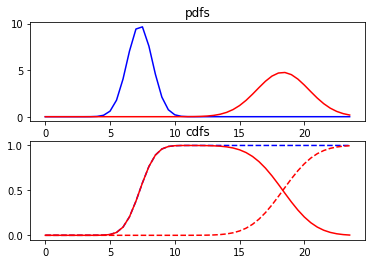

In [77]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [78]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.30400155, 0.04040827, 0.76442519, 0.08391565])

In [79]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


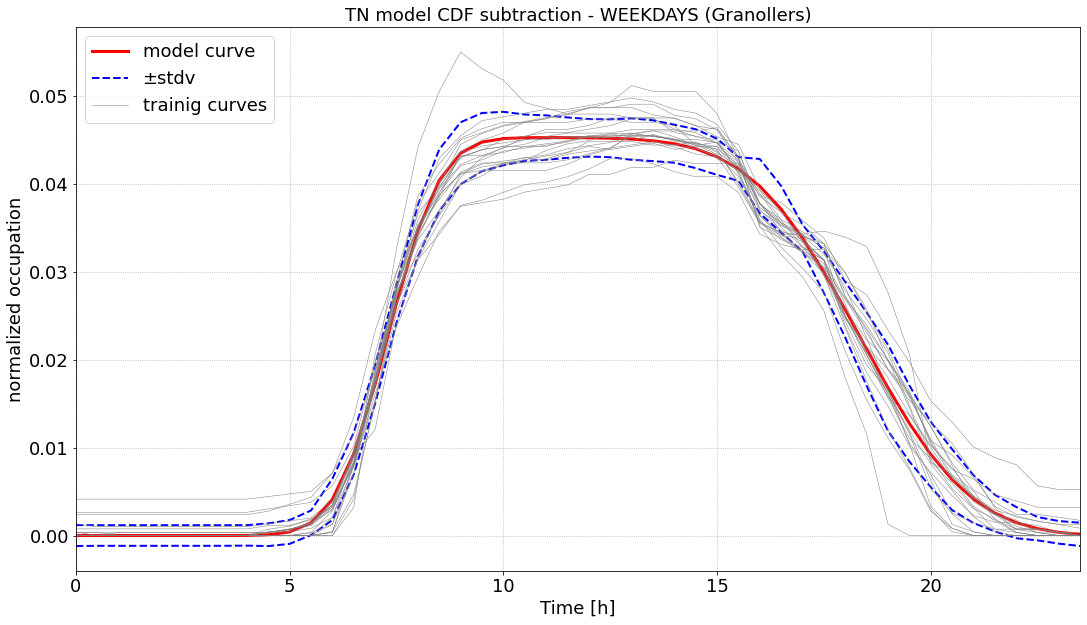

In [80]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [81]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))
    optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


In [82]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00716

stdv per time-step


In [83]:
optimal_params_fridaytn

 final_simplex: (array([[0.30433253, 0.0278728 , 0.69046737, 0.08251946],
       [0.30433243, 0.02787331, 0.69046703, 0.08251892],
       [0.30433293, 0.02787345, 0.69046735, 0.08251995],
       [0.30433299, 0.02787257, 0.69046744, 0.08251959],
       [0.30433249, 0.027873  , 0.69046785, 0.08251858]]), array([0.01476129, 0.01476129, 0.01476129, 0.01476129, 0.01476129]))
           fun: 0.01476128719619324
       message: 'Optimization terminated successfully.'
          nfev: 234
           nit: 134
        status: 0
       success: True
             x: array([0.30433253, 0.0278728 , 0.69046737, 0.08251946])

In [84]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [85]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

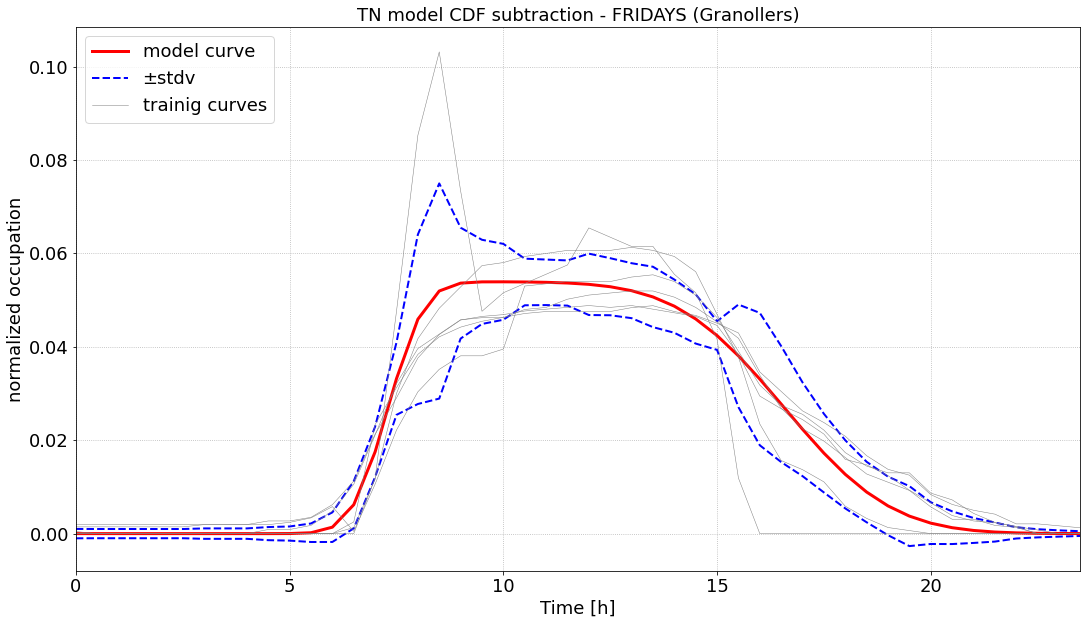

In [86]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [87]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))    
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
        #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     

        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
        

## save the model fits

In [88]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFit.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [89]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.00849



In [90]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([3.10056192e-01, 1.06707572e-01, 4.49442270e+02, 1.04077069e+01])

In [91]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



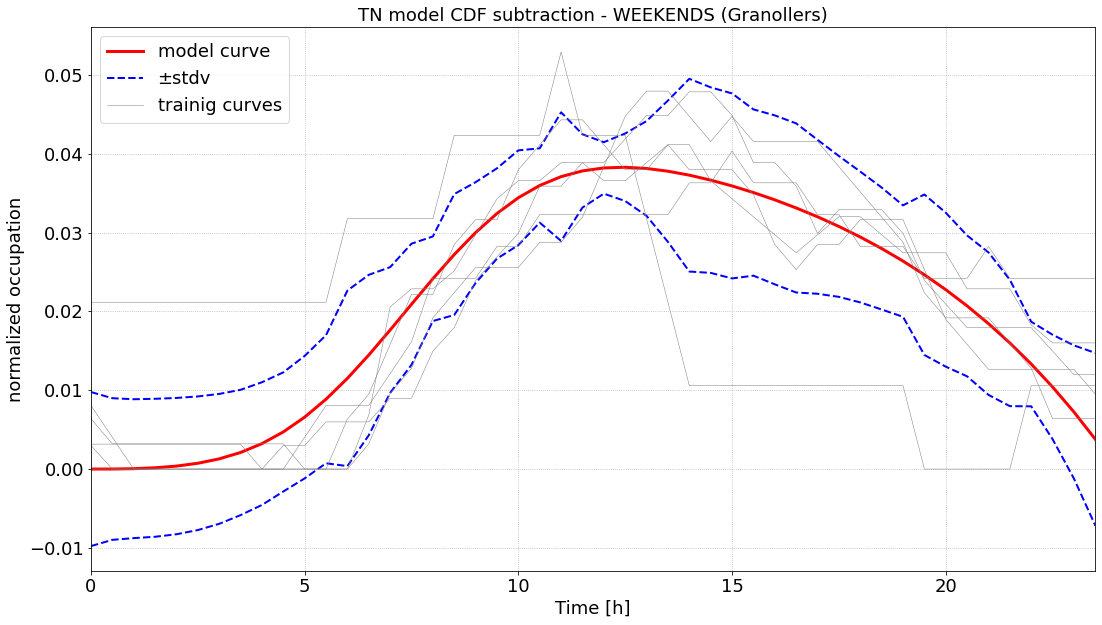

In [92]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [93]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Granollers -----------
Mean Arrival Time   = 07:17h
stdv Arrival        =  0:58h
Mean Departure Time = 18:20h
stdv Departure      =  2:00h
--------- FRIDAYS Granollers -----------
Mean Arrival Time   = 07:18h
stdv Arrival        =  0:40h
Mean Departure Time = 16:34h
stdv Departure      =  1:58h
--------- WEEKENDS Granollers -----------
Mean Arrival Time   = 07:26h
stdv Arrival        =  2:33h
Mean Departure Time = 10786:36h
stdv Departure      = 249:47h


In [94]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [95]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [96]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [97]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
6.146439319028374  ±  2.9730751960647583
7.136587078651686  ±  2.671826417485919
4.224563007937272  ±  2.316905748944554
4.177123467089406  ±  2.131848519997743
7.5673350605430825  ±  4.389846019757531
1.5262820994736224  ±  0.0
2.8419561658782655  ±  0.0


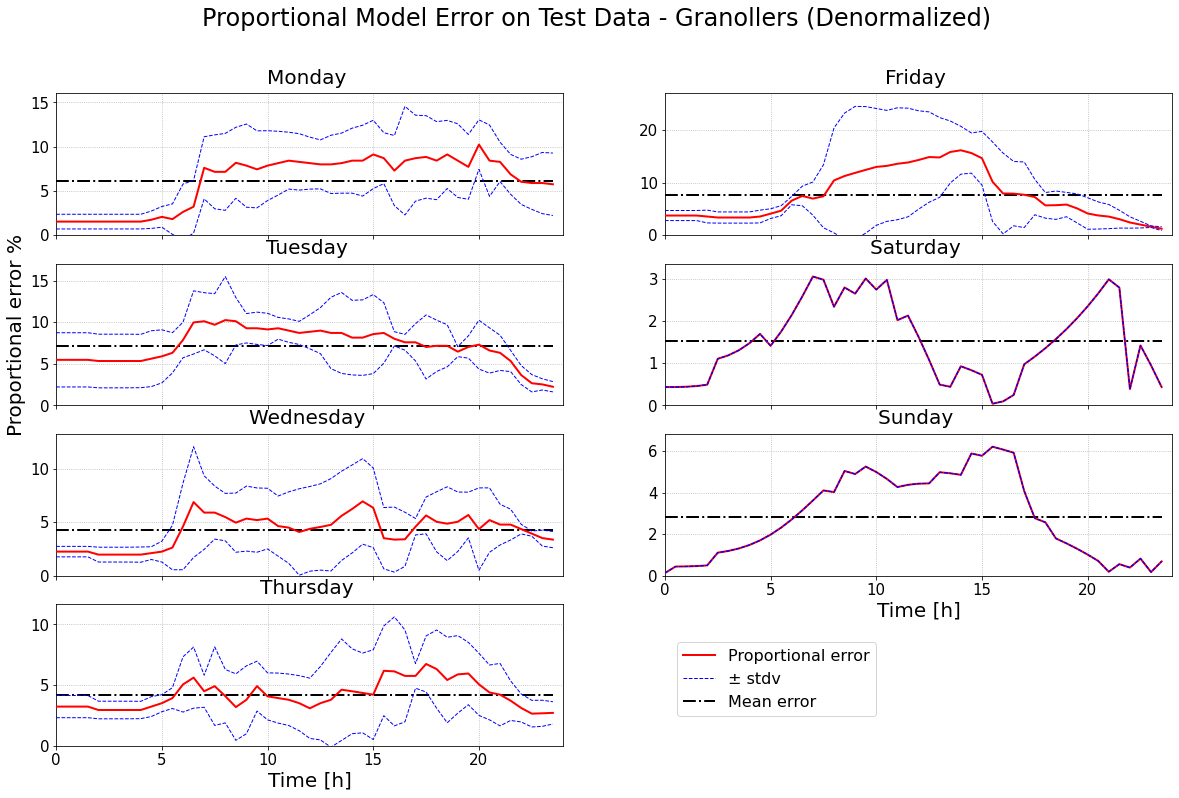

In [98]:
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [99]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [100]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [101]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

#### MONDAY

In [102]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 14
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-17
Real Monday scaled prtotype error:  3.32 %
Real Monday scaled prtotype STDV:  2.4834812534003263
Real Monday scaled TN error:  3.68 %
Real Monday scaled TN STDV:  2.494049573847761
_____________________________________________________________
2020-02-24
Real Monday scaled prtotype error:  2.94 %
Real Monday scaled prtotype STDV:  2.351323060844822
Real Monday scaled TN error:  3.04 %
Real Monday scaled TN STDV:  2.297026372647297
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  5.66 %
Real Monday scaled prtotype STDV:  3.327810023093177
Real Monday scaled TN error:  5.93 %
Real Monday scaled TN STDV:  2.7659073817443254
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  2.48 %
Real Monday scaled prtotype STDV:  1.9873316719388932
Real Monday scaled TN error:  2.7 %
Real Monday scaled TN STDV:  1.8725264714385812
_______________________________________________

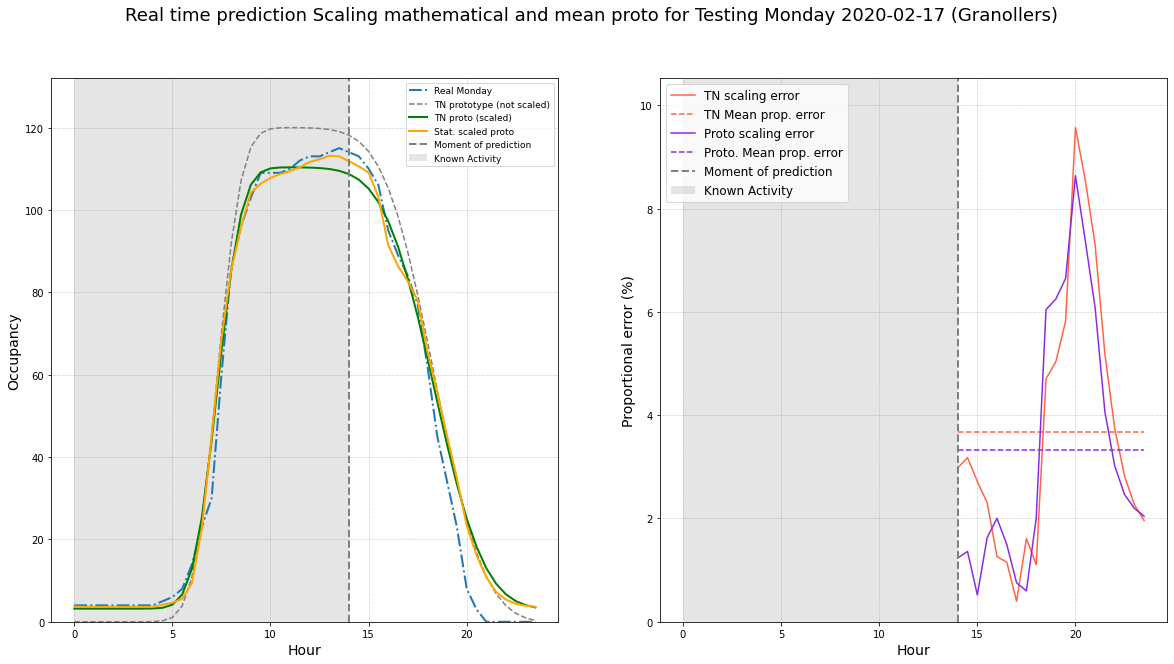

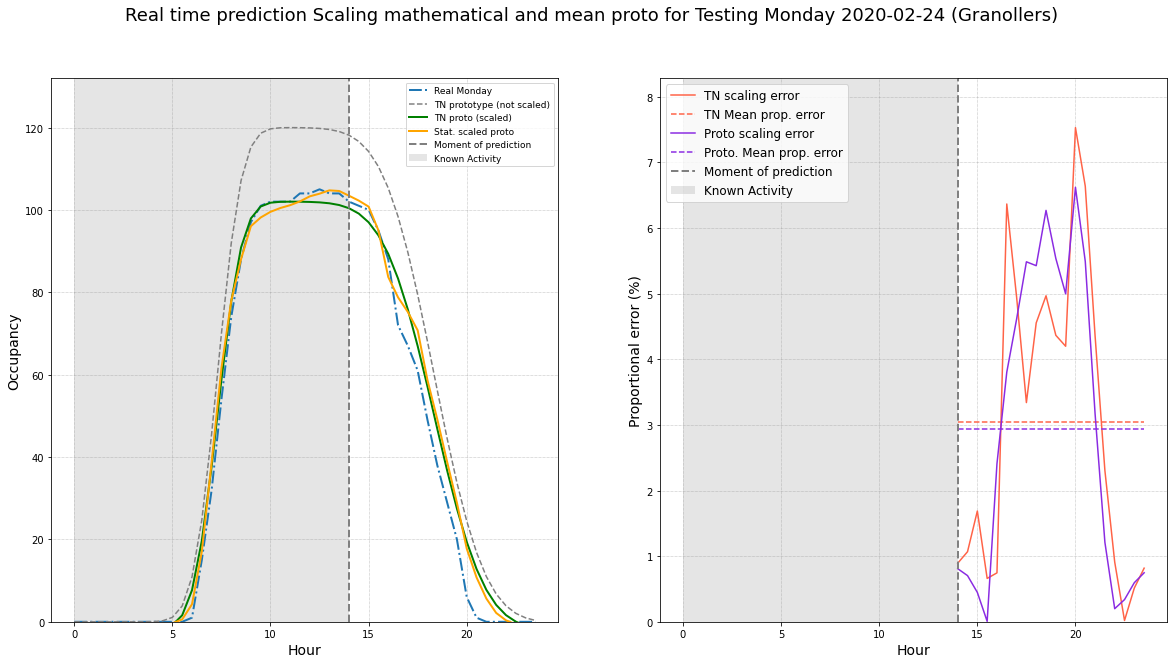

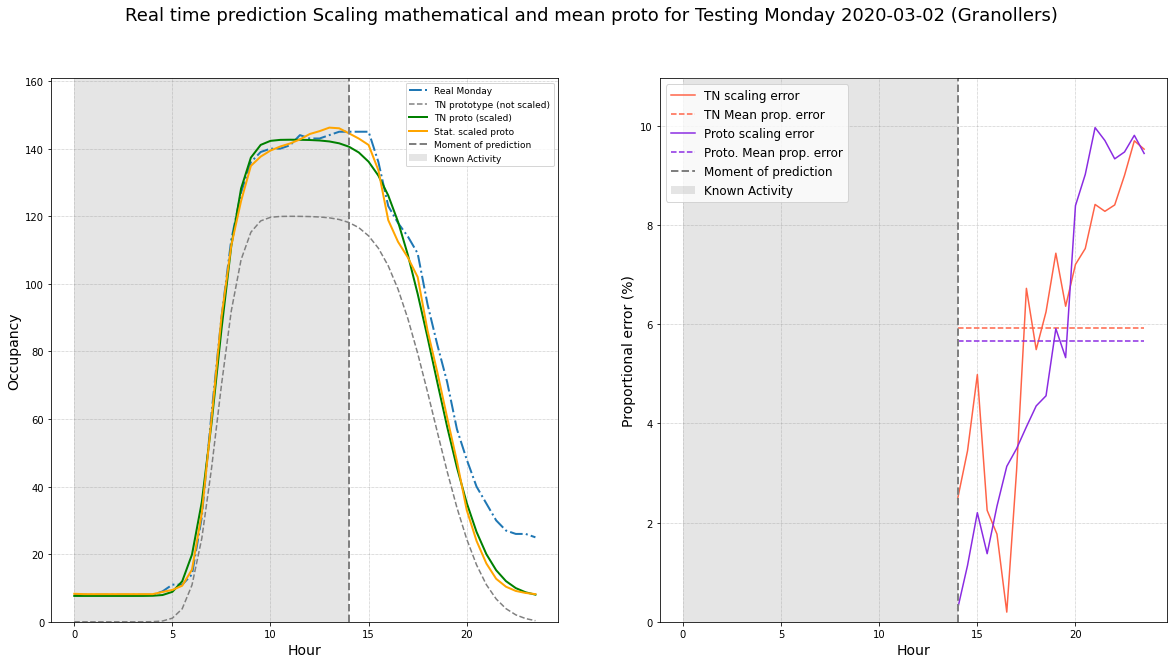

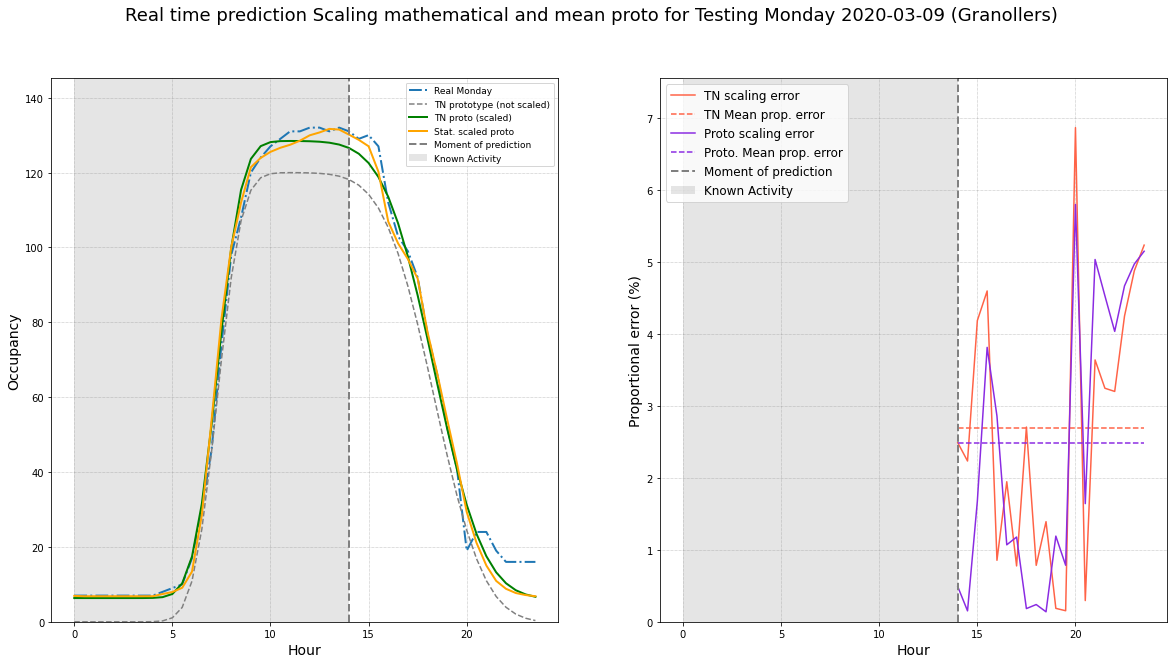

In [103]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [104]:
starting_hour=7.5

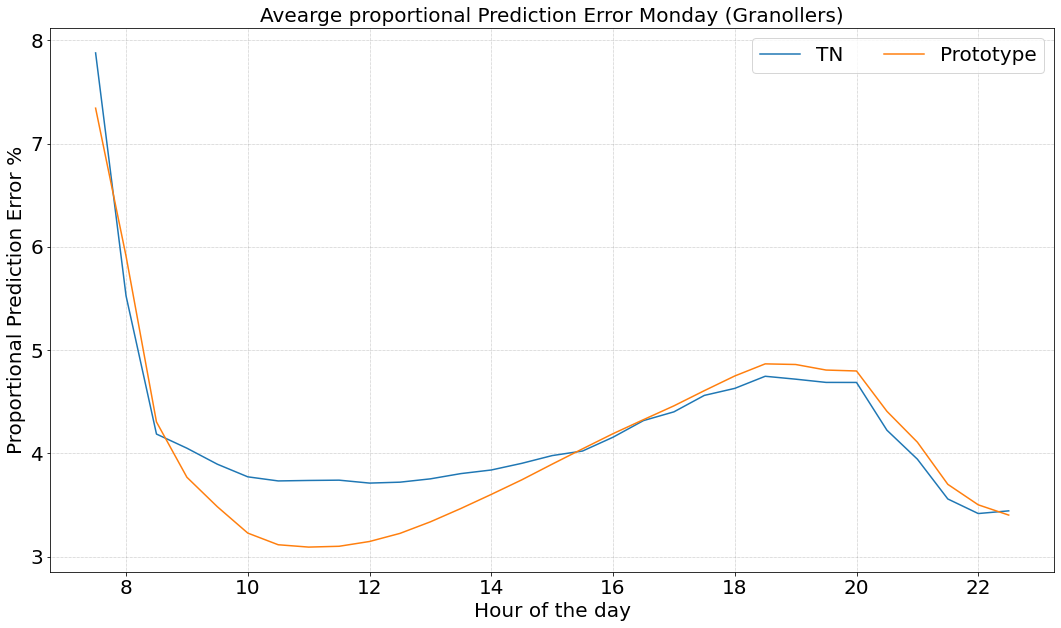

In [105]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [106]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

2020-02-17
Real Monday scaled prtotype error:  3.79 %
Real Monday scaled prtotype STDV:  3.174083881503197
Real Monday scaled TN error:  4.08 %
Real Monday scaled TN STDV:  3.107443042783707
_____________________________________________________________
2020-02-24
Real Monday scaled prtotype error:  4.48 %
Real Monday scaled prtotype STDV:  2.878791468146132
Real Monday scaled TN error:  4.63 %
Real Monday scaled TN STDV:  3.041226861767024
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  5.81 %
Real Monday scaled prtotype STDV:  3.609439301090682
Real Monday scaled TN error:  5.86 %
Real Monday scaled TN STDV:  3.6248257485703204
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  2.43 %
Real Monday scaled prtotype STDV:  2.0432738266562995
Real Monday scaled TN error:  2.55 %
Real Monday scaled TN STDV:  2.1805499324428097
_______________________________________________

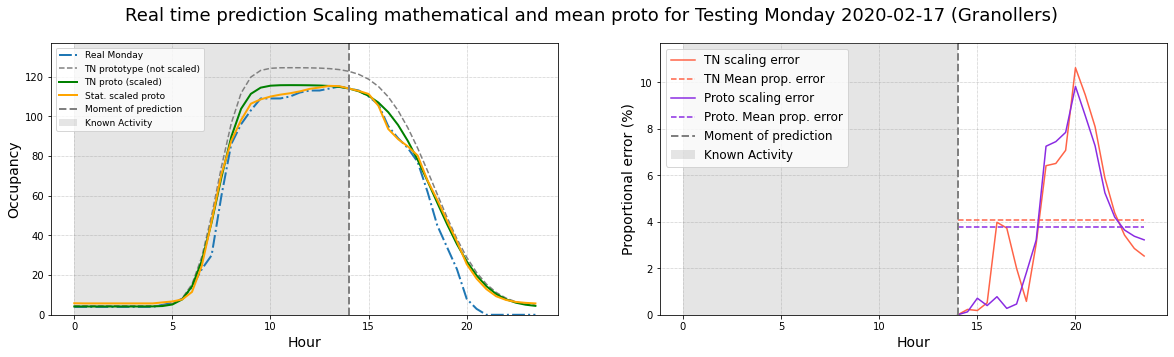

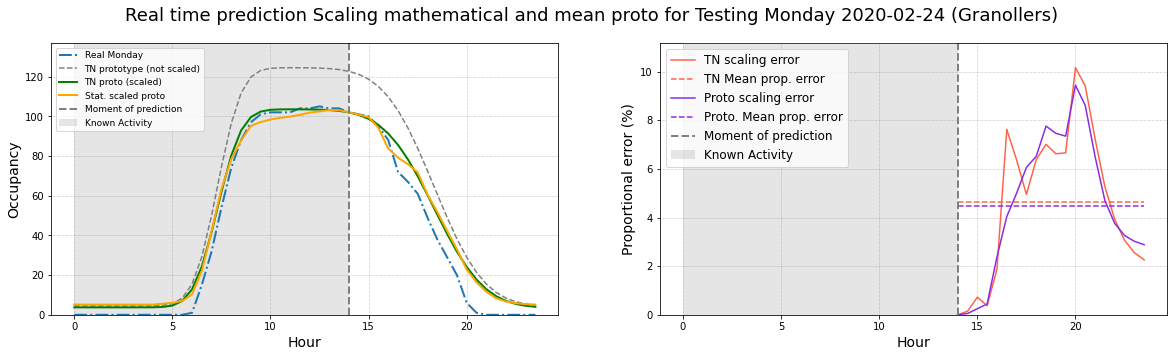

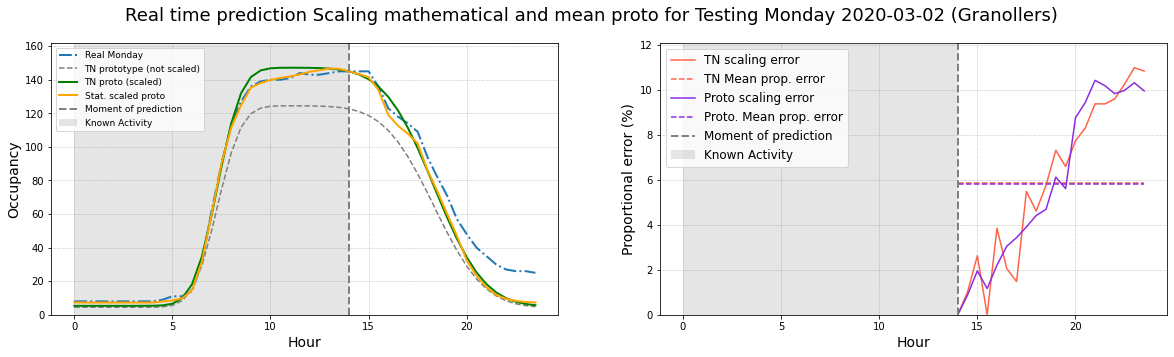

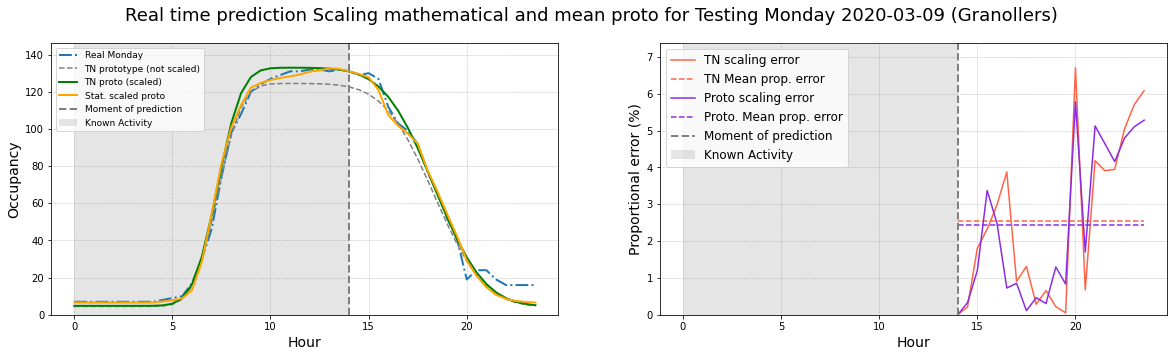

In [107]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

#### TUESDAY

In [108]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-18
Real Tuesday scaled prtotype error:  2.43 %
Real Tuesday scaled prtotype STDV:  1.6797023620045957
Real Tuesday scaled TN error:  3.32 %
Real Tuesday scaled TN STDV:  2.267767548956551
_____________________________________________________________
2020-02-25
Real Tuesday scaled prtotype error:  1.88 %
Real Tuesday scaled prtotype STDV:  1.1020941217717748
Real Tuesday scaled TN error:  2.79 %
Real Tuesday scaled TN STDV:  2.0359443236326342
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  5.11 %
Real Tuesday scaled prtotype STDV:  2.0345474081549
Real Tuesday scaled TN error:  4.3 %
Real Tuesday scaled TN STDV:  3.059349373968064
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  1.28 %
Real Tuesday scaled prtotype STDV:  1.0146048142953403
Real Tuesday scaled TN error:  2.16 %
Real Tuesday scaled TN STDV:  1.6319193555228093
________________________________

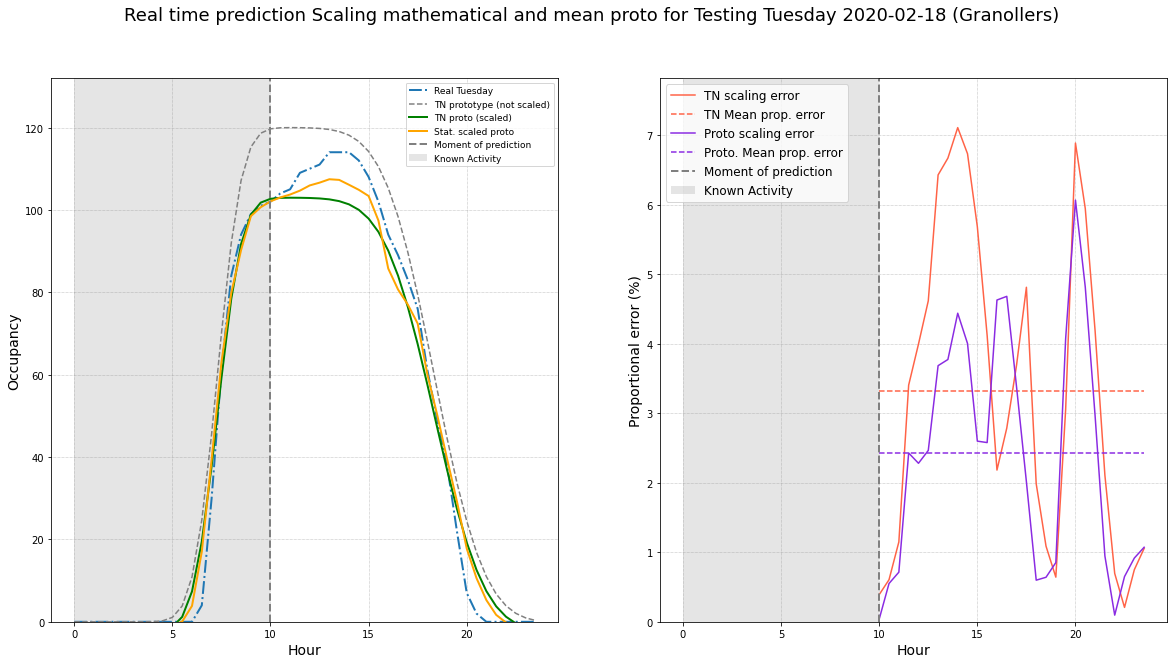

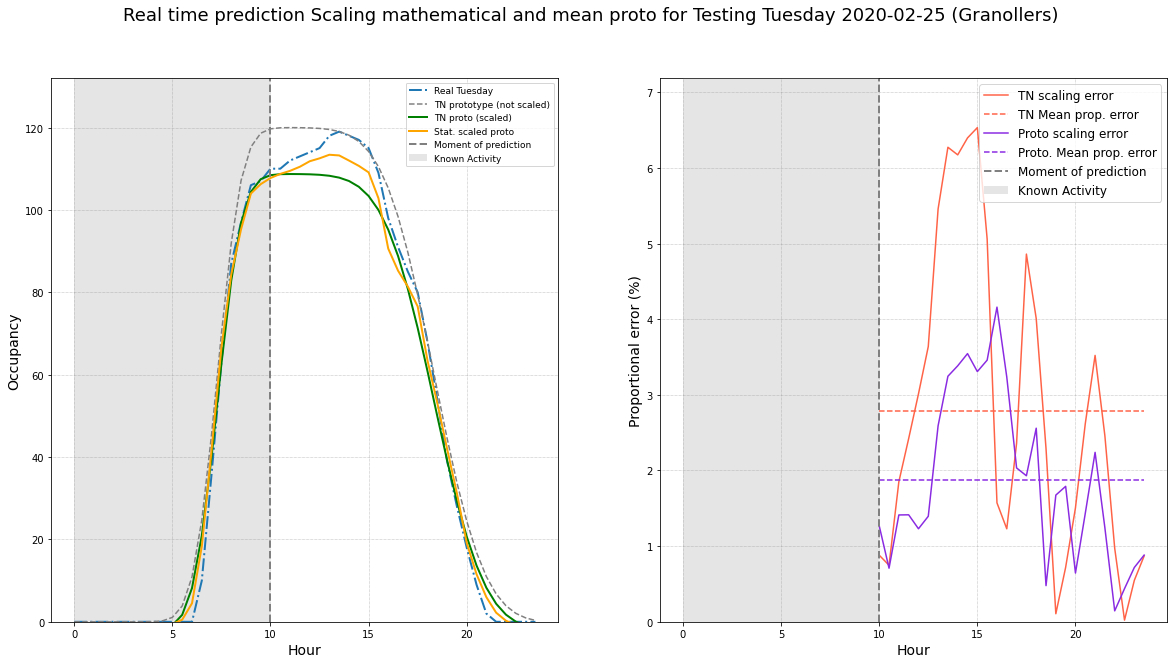

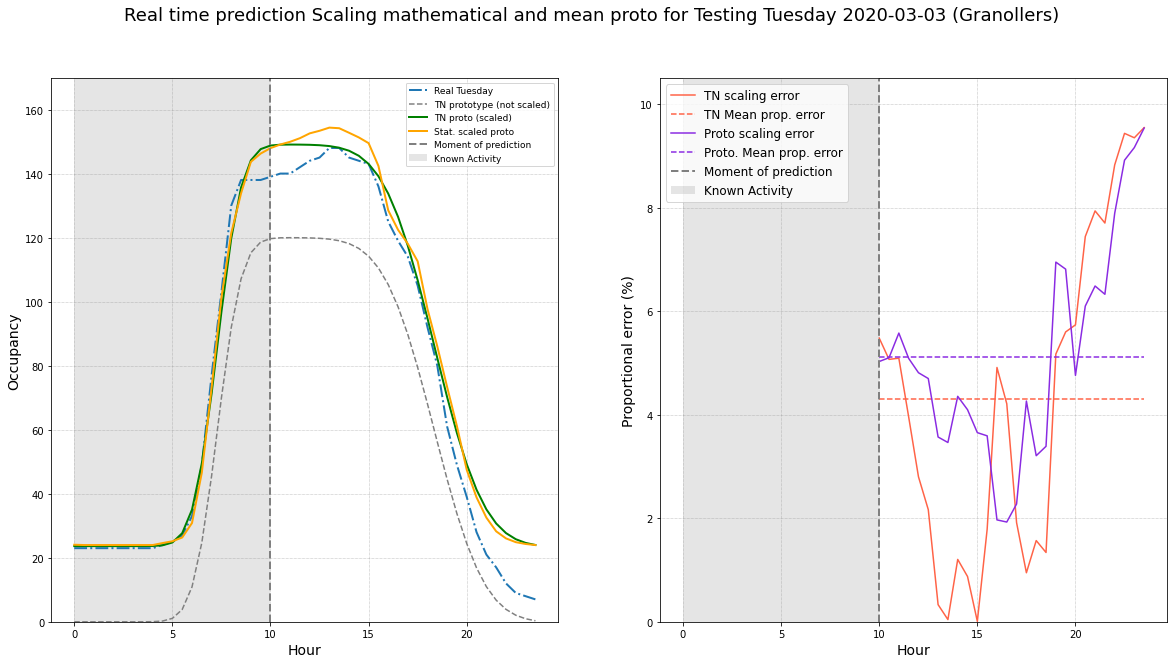

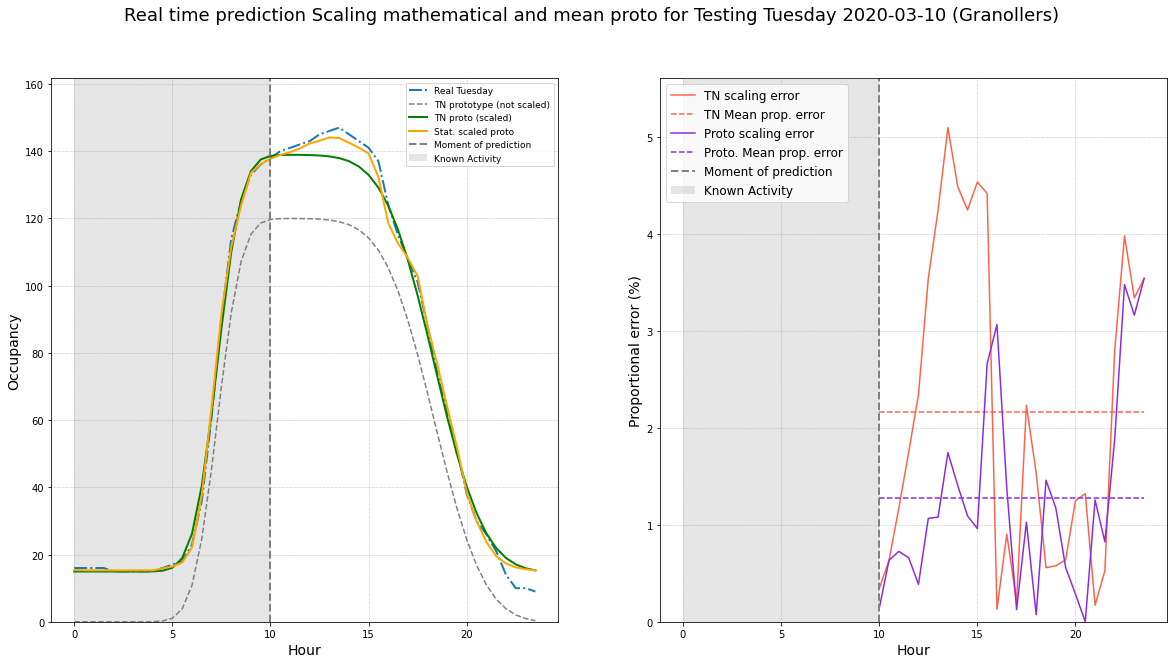

In [109]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

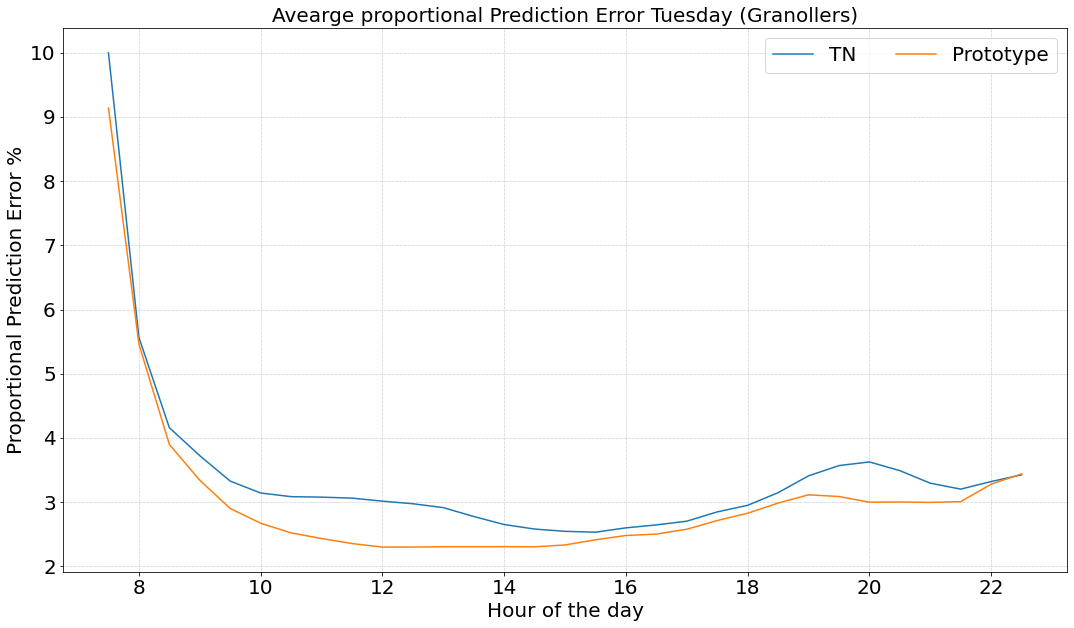

In [110]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [111]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-18
Real Tuesday scaled prtotype error:  3.53 %
Real Tuesday scaled prtotype STDV:  2.1729724829518475
Real Tuesday scaled TN error:  4.14 %
Real Tuesday scaled TN STDV:  2.5442045659016146
_____________________________________________________________
2020-02-25
Real Tuesday scaled prtotype error:  2.32 %
Real Tuesday scaled prtotype STDV:  1.8750752400922406
Real Tuesday scaled TN error:  3.03 %
Real Tuesday scaled TN STDV:  1.982198922563763
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  1.62 %
Real Tuesday scaled prtotype STDV:  1.3879883278369547
Real Tuesday scaled TN error:  3.09 %
Real Tuesday scaled TN STDV:  1.9588252512285897
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  1.68 %
Real Tuesday scaled prtotype STDV:  1.4717084583498152
Real Tuesday scaled TN error:  3.23 %
Real Tuesday scaled TN STDV:  1.5912157108039062
___________________________

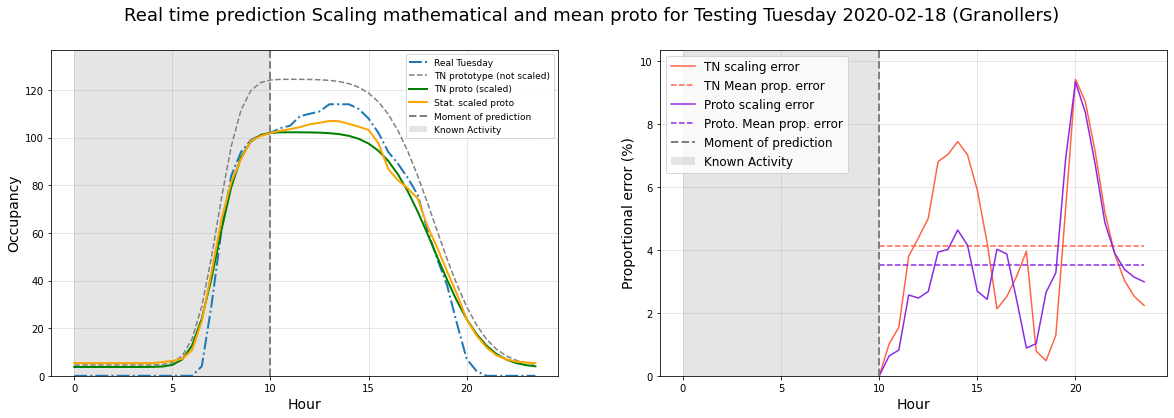

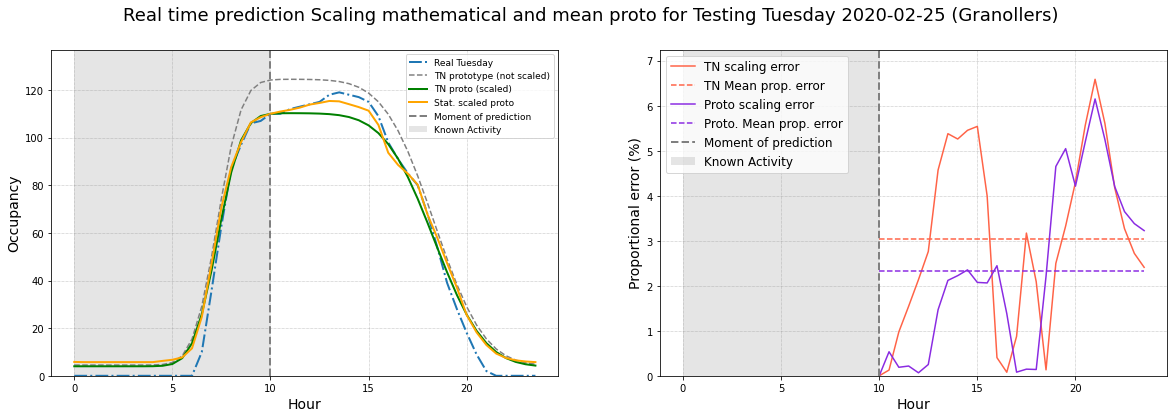

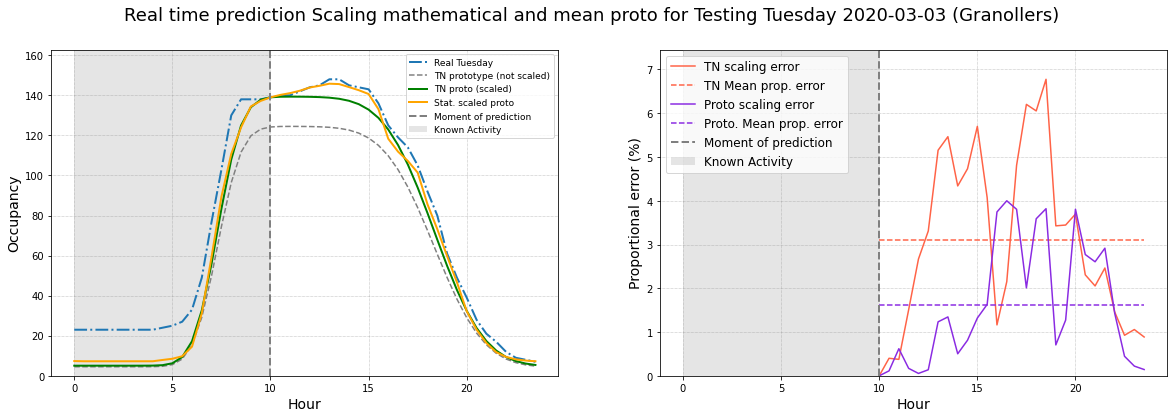

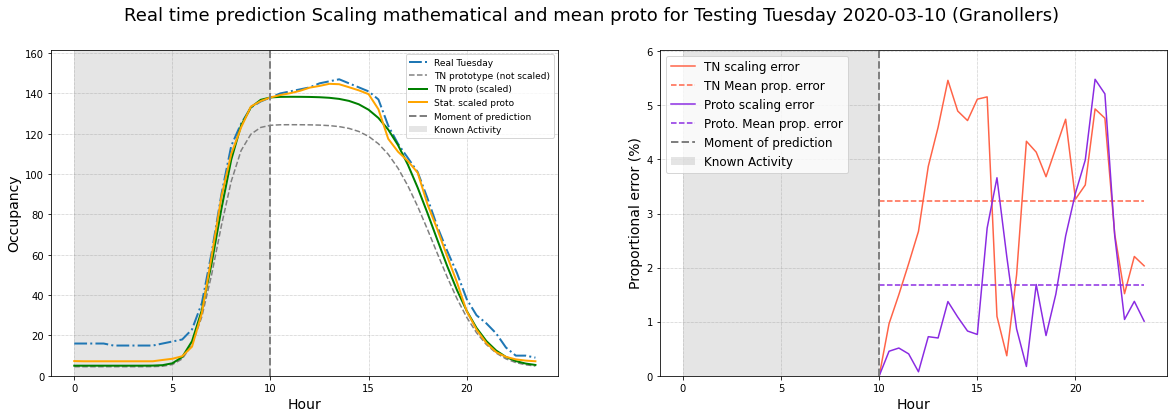

In [112]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

In [113]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-19
Real Wednesday scaled prtotype error:  3.81 %
Real Wednesday scaled prtotype STDV:  1.9838014176385719
Real Wednesday scaled TN error:  4.27 %
Real Wednesday scaled TN STDV:  2.378837405960113
_____________________________________________________________
2020-02-26
Real Wednesday scaled prtotype error:  2.48 %
Real Wednesday scaled prtotype STDV:  1.5868458212466319
Real Wednesday scaled TN error:  3.26 %
Real Wednesday scaled TN STDV:  2.0415230826857615
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  2.67 %
Real Wednesday scaled prtotype STDV:  1.6947858766149004
Real Wednesday scaled TN error:  3.14 %
Real Wednesday scaled TN STDV:  1.411824045678627
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  1.77 %
Real Wednesday scaled prtotype STDV:  1.0668111490668257
Real Wednesday scaled TN error:  2.72 %
Real Wednesday scaled TN STDV:  1.2436296121846

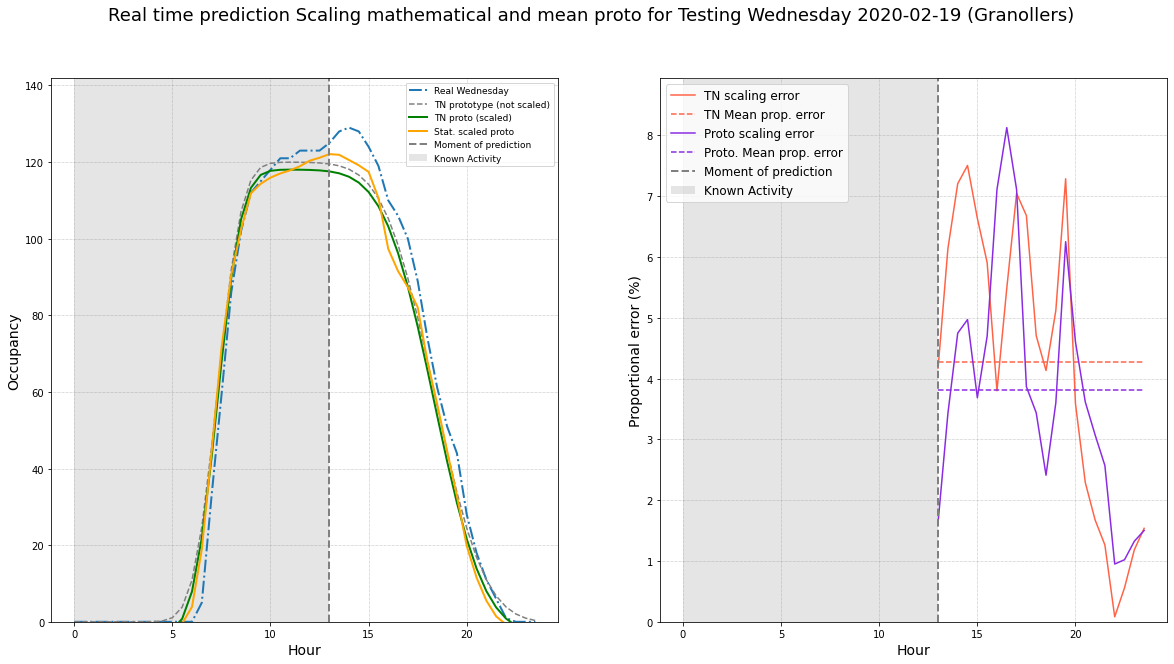

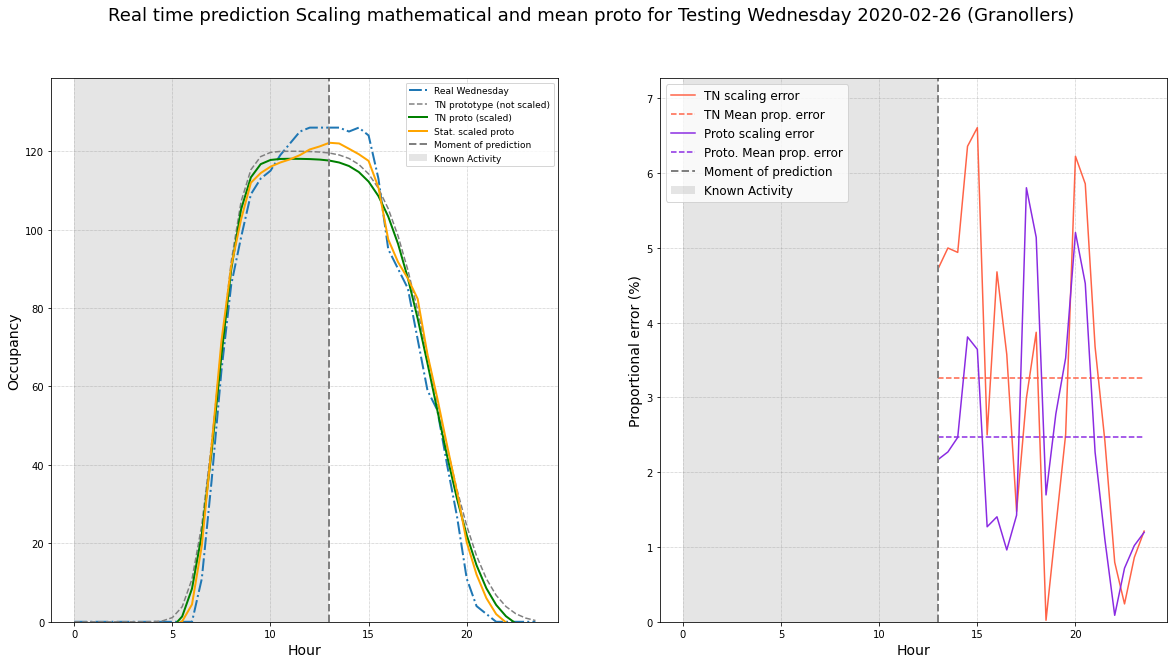

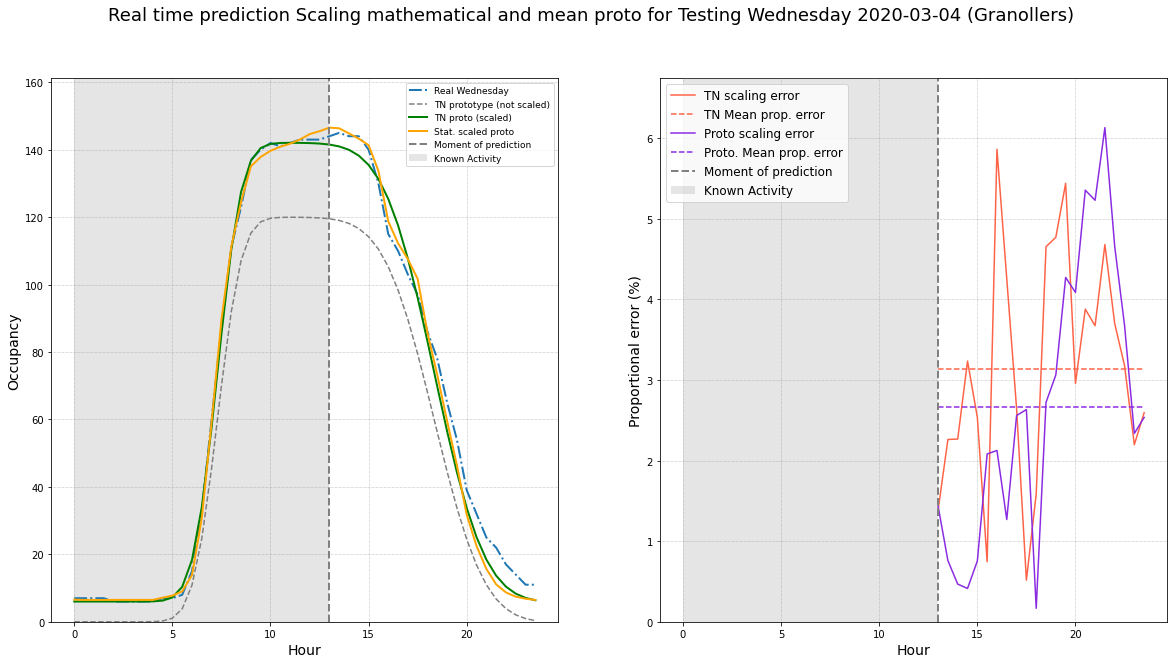

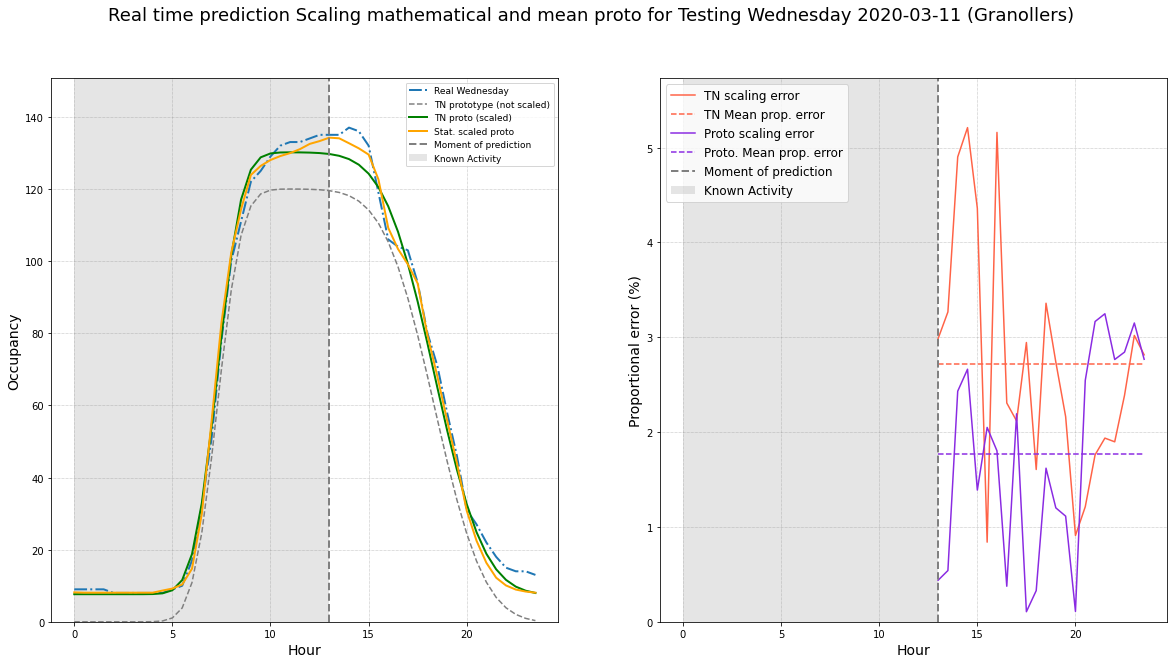

In [114]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

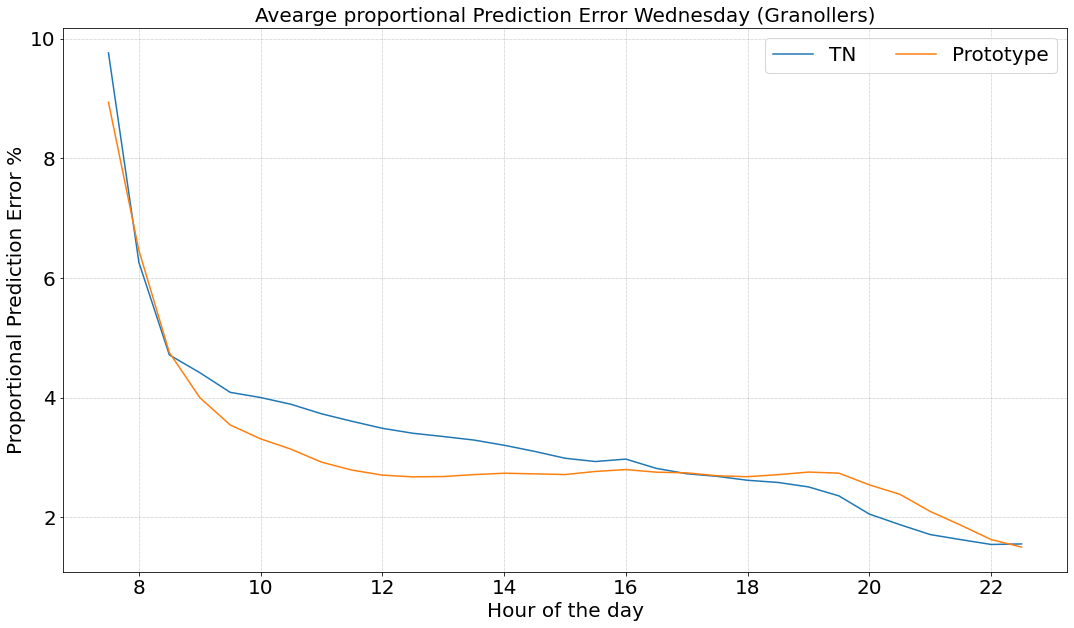

In [115]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [116]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-19
Real Wednesday scaled prtotype error:  2.41 %
Real Wednesday scaled prtotype STDV:  1.6051312028656435
Real Wednesday scaled TN error:  2.09 %
Real Wednesday scaled TN STDV:  1.203606868147936
_____________________________________________________________
2020-02-26
Real Wednesday scaled prtotype error:  4.54 %
Real Wednesday scaled prtotype STDV:  2.9284484427100628
Real Wednesday scaled TN error:  5.04 %
Real Wednesday scaled TN STDV:  3.1715889812305447
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  2.41 %
Real Wednesday scaled prtotype STDV:  1.7274994896998155
Real Wednesday scaled TN error:  3.07 %
Real Wednesday scaled TN STDV:  1.830573362147302
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  1.98 %
Real Wednesday scaled prtotype STDV:  1.3490567679451
Real Wednesday scaled TN error:  2.56 %
Real Wednesday scaled TN STDV:  1.766759554062297


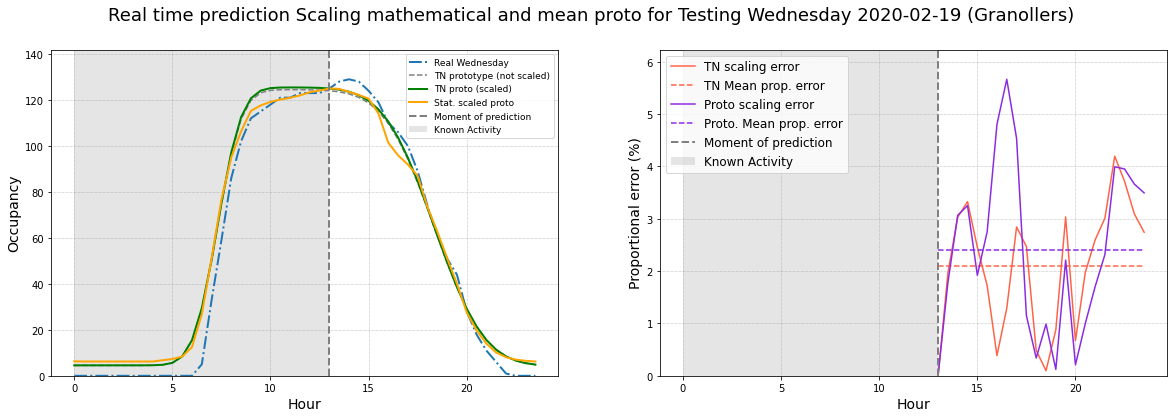

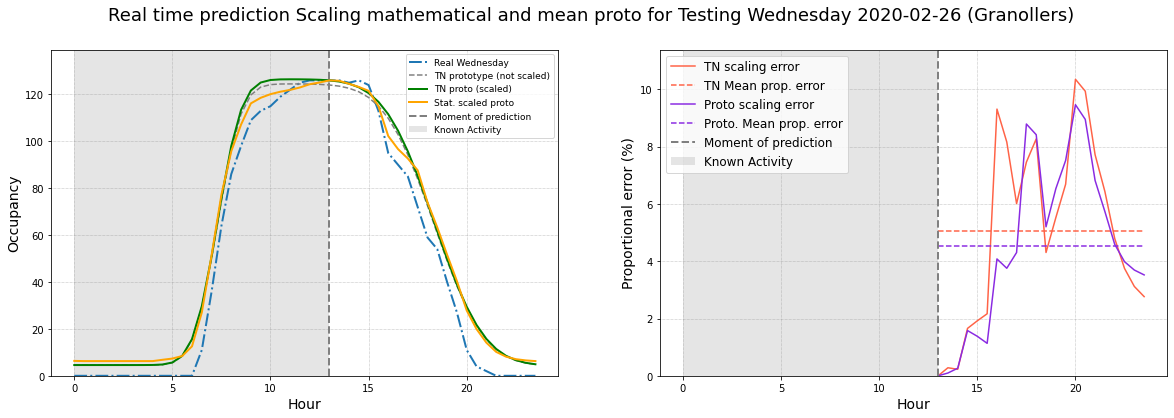

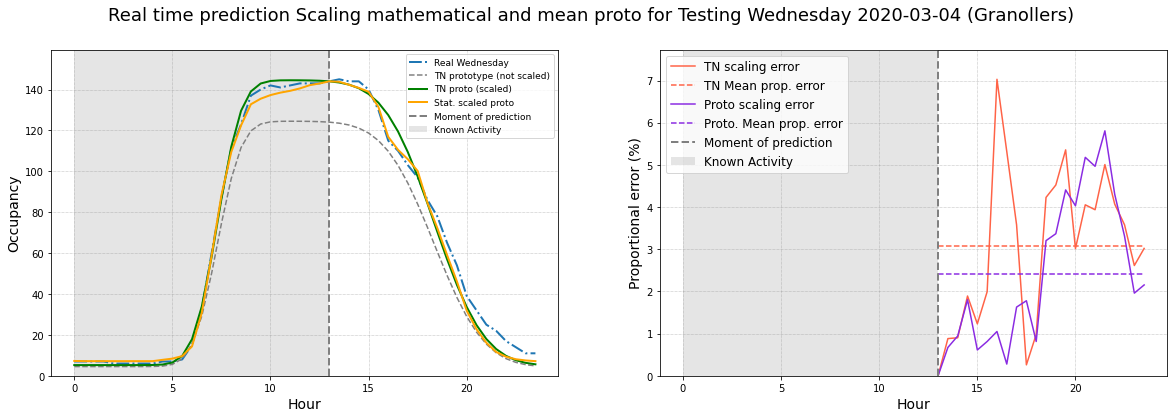

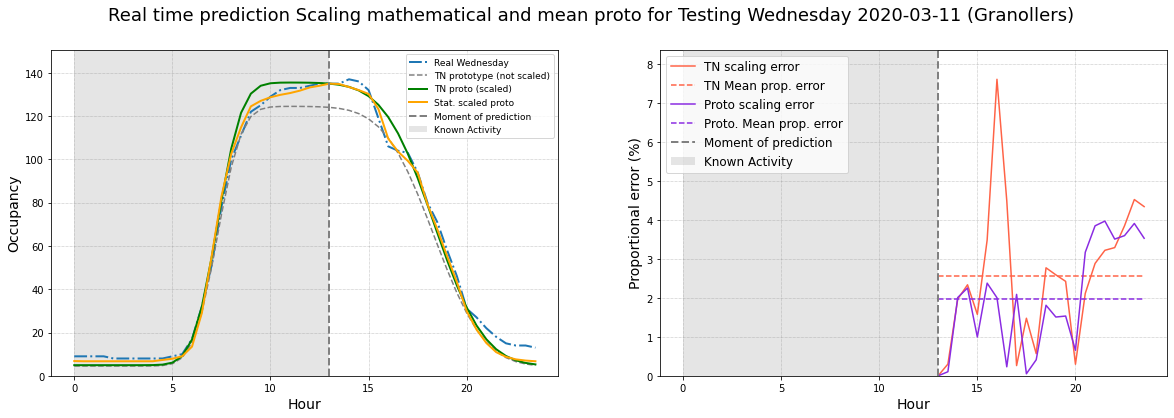

In [117]:
tn_proto = tn_weekday
cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

In [118]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-20
Real Thursday scaled prtotype error:  11.52 %
Real Thursday scaled prtotype STDV:  3.7082180938290414
Real Thursday scaled TN error:  18.67 %
Real Thursday scaled TN STDV:  7.704356077174092
_____________________________________________________________
2020-02-27
Real Thursday scaled prtotype error:  18.05 %
Real Thursday scaled prtotype STDV:  12.170847475302454
Real Thursday scaled TN error:  22.81 %
Real Thursday scaled TN STDV:  15.051517894192965
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  6.16 %
Real Thursday scaled prtotype STDV:  4.016926953406503
Real Thursday scaled TN error:  3.14 %
Real Thursday scaled TN STDV:  2.167103154075961
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  9.8 %
Real Thursday scaled prtotype STDV:  6.159860355239741
Real Thursday scaled TN error:  2.34 %
Real Thursday scaled TN STDV:  2.6175698008749553
___________

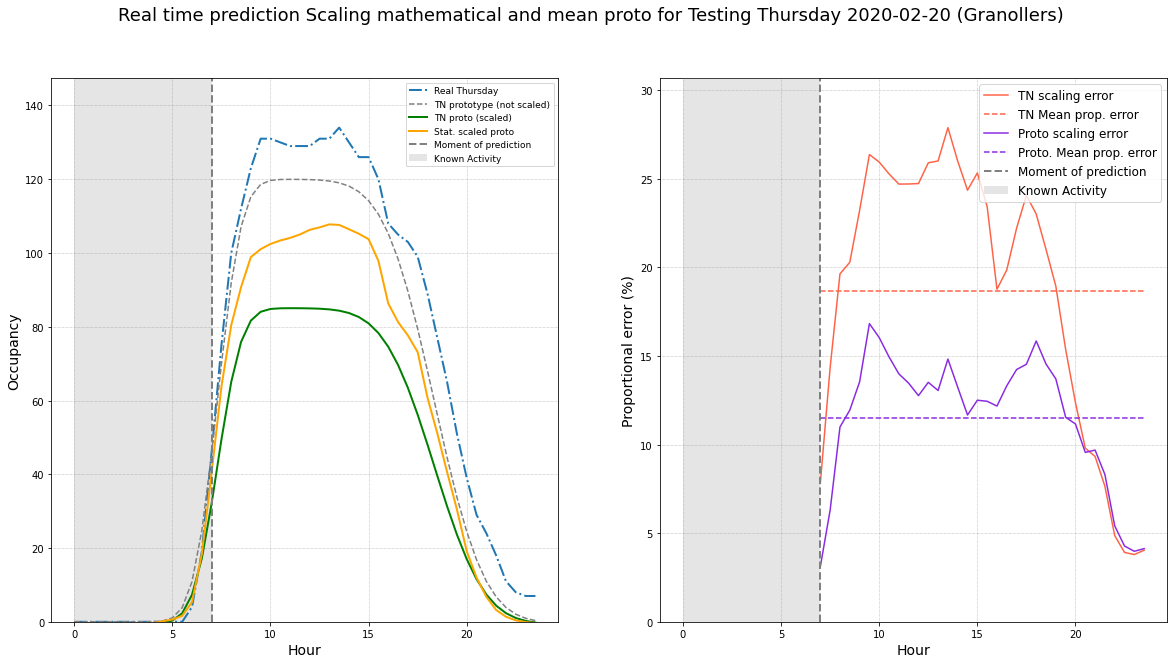

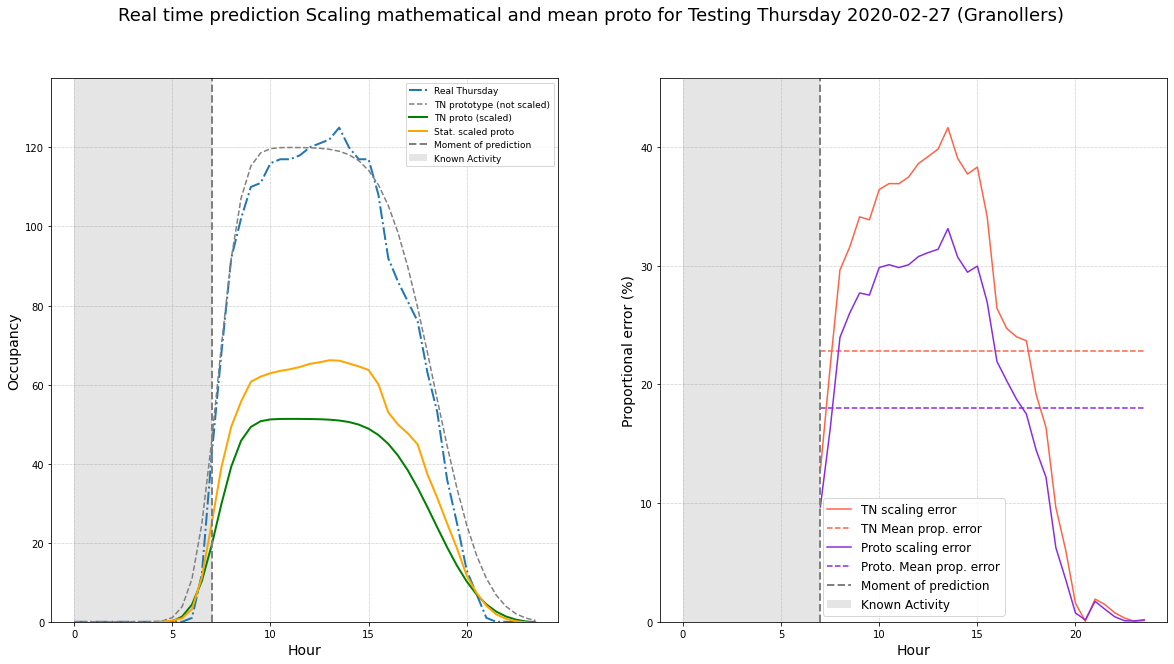

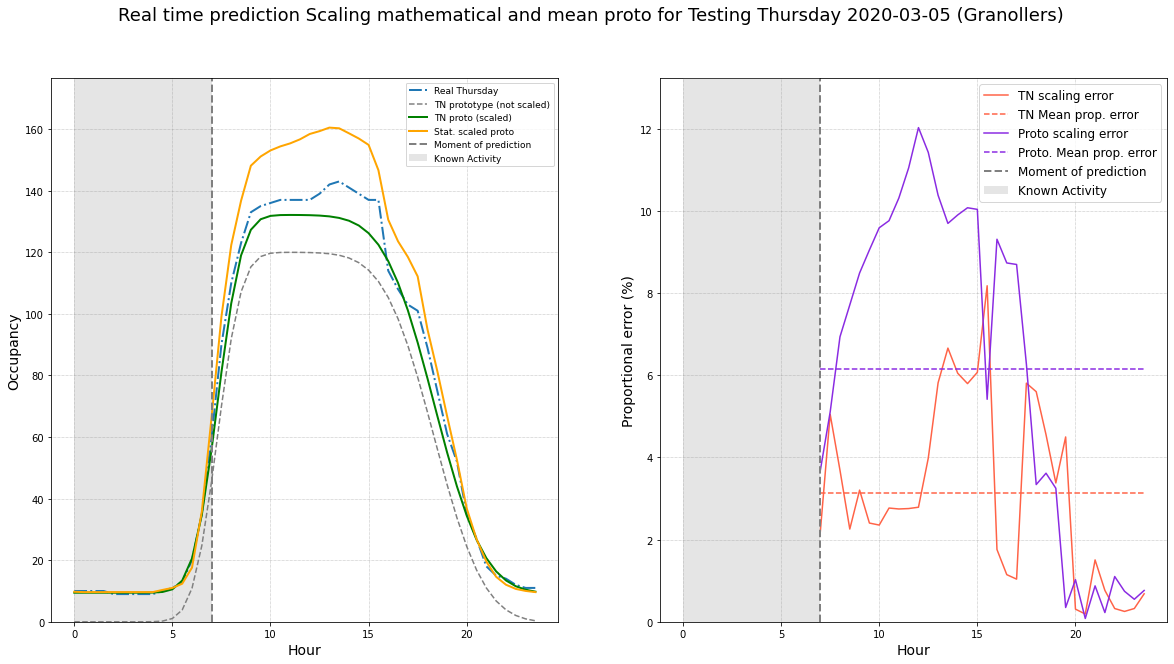

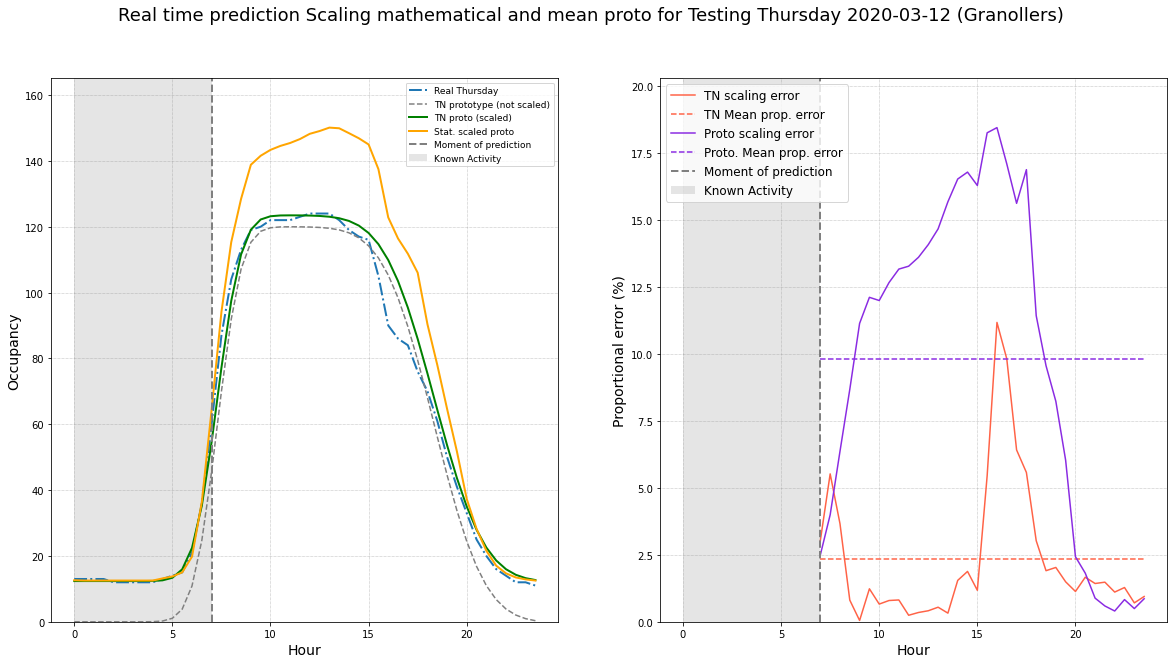

In [119]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

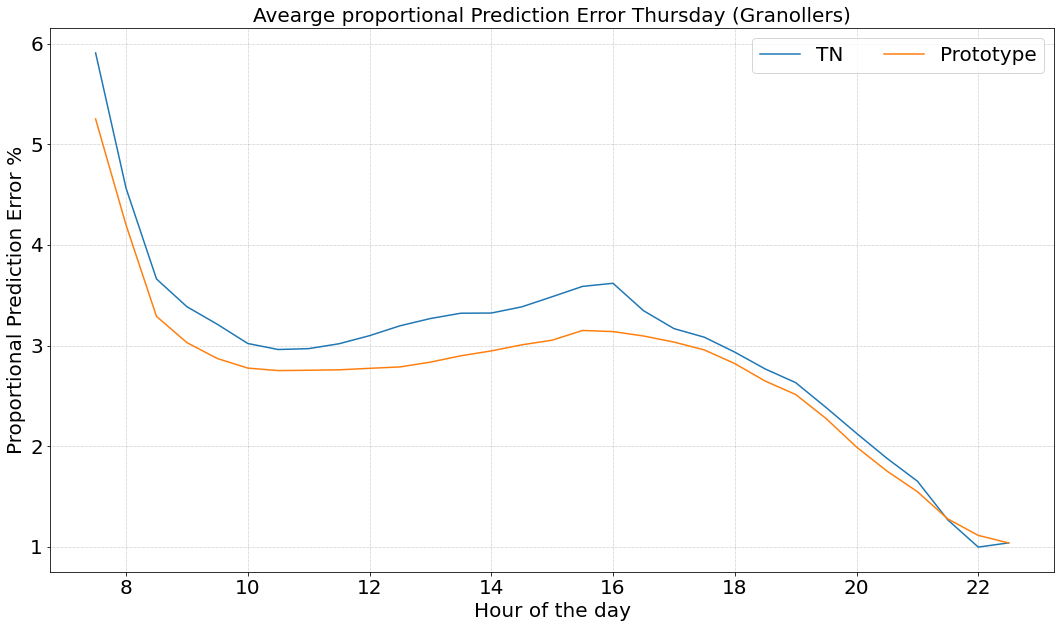

In [120]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [121]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

In [122]:
def plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking) :
    fsize=20
    limit_hour_vec = np.arange (starting_hour, 23, 0.5)
    plt.figure(figsize=(18,10));
    plt.plot(limit_hour_vec,np.mean(tn_running_error_vec,axis=1),color='b',label='TN')
    plt.plot(limit_hour_vec,np.mean(tn_running_error_vec,axis=1)+np.std(tn_running_error_vec,axis=1),
             linestyle='dashed',color='b',label='TN±stdv')
    plt.plot(limit_hour_vec,np.mean(tn_running_error_vec,axis=1)-np.std(tn_running_error_vec,axis=1),
             linestyle='dashed',color='b')
    plt.plot(limit_hour_vec,np.mean(proto_running_error_vec,axis=1),color='r',label='Prototype')
    #plt.plot(limit_hour_vec,np.mean(proto_running_error_vec,axis=1)+np.std(proto_running_error_vec,axis=1),
    #         linestyle='dashed',color='r',label='Prototype±stdv')
    #plt.plot(limit_hour_vec,np.mean(proto_running_error_vec,axis=1)-np.std(proto_running_error_vec,axis=1),
    #         linestyle='dashed',color='r')
    plt.title("Avearge proportional Prediction Error " + day +  ' ('+ current_parking+')', fontsize=fsize)
    plt.ylabel("Proportional Prediction Error %",fontsize=fsize);
    plt.xlabel("Hour of the day",fontsize=fsize);
    plt.yticks(fontsize=fsize)
    plt.xticks(fontsize=fsize);
    plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
    plt.legend(fontsize=fsize, loc="best",ncol=2);


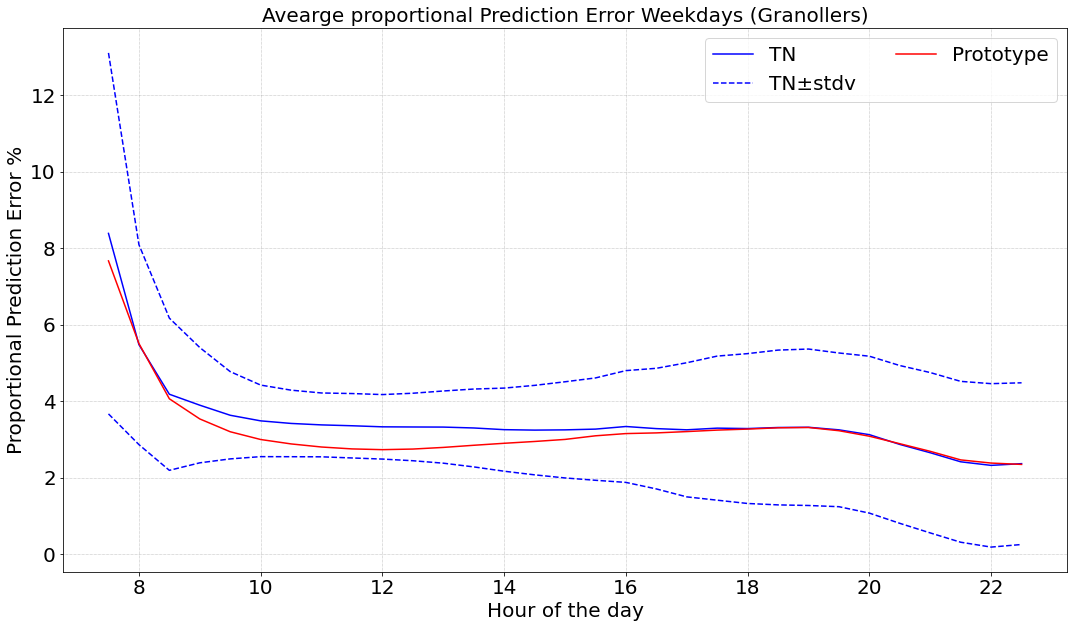

In [123]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

2020-02-20
Real Thursday scaled prtotype error:  8.55 %
Real Thursday scaled prtotype STDV:  3.8757872315709974
Real Thursday scaled TN error:  7.26 %
Real Thursday scaled TN STDV:  3.419314489220391
_____________________________________________________________
2020-02-27
Real Thursday scaled prtotype error:  6.34 %
Real Thursday scaled prtotype STDV:  3.4150535040327705
Real Thursday scaled TN error:  5.24 %
Real Thursday scaled TN STDV:  3.189361371122077
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  2.01 %
Real Thursday scaled prtotype STDV:  1.0273692422869691
Real Thursday scaled TN error:  3.58 %
Real Thursday scaled TN STDV:  2.7057661543931277
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  8.45 %
Real Thursday scaled prtotype STDV:  5.377482552132204
Real Thursday scaled TN error:  10.02 %
Real Thursday scaled TN STDV:  6.7461188160326016
____________

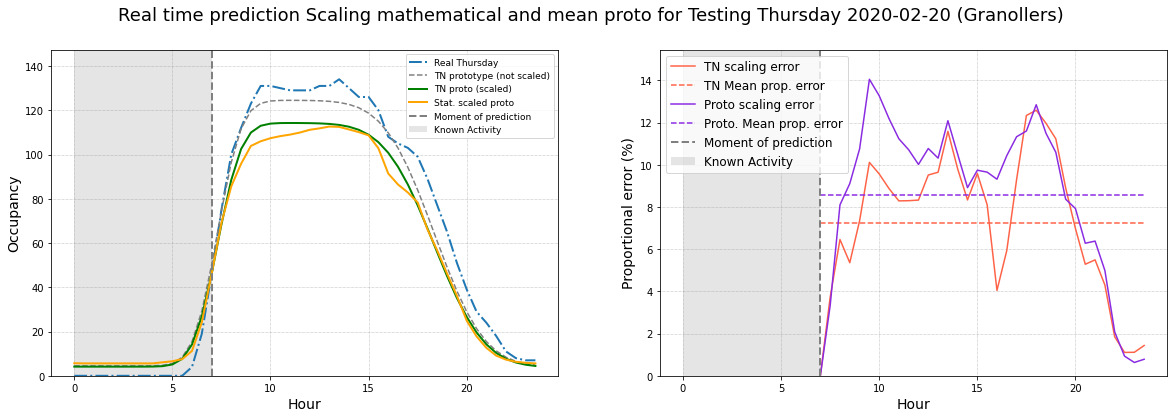

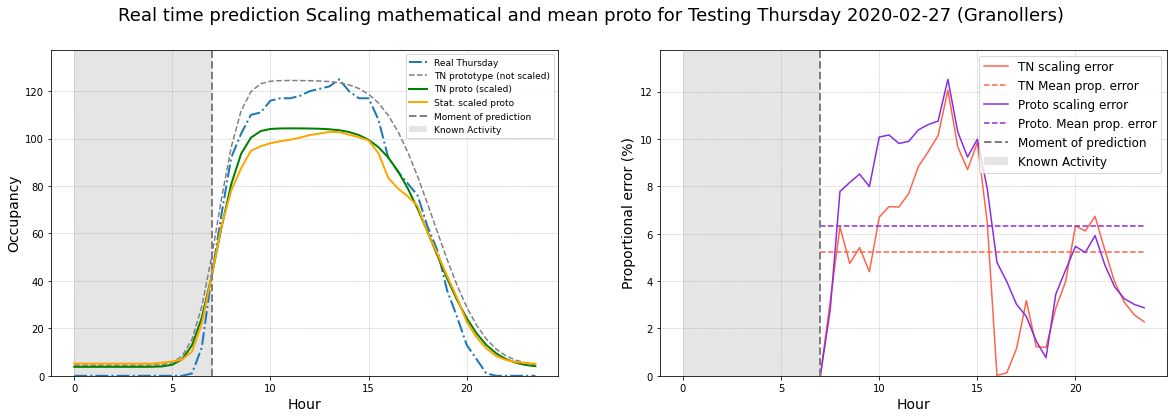

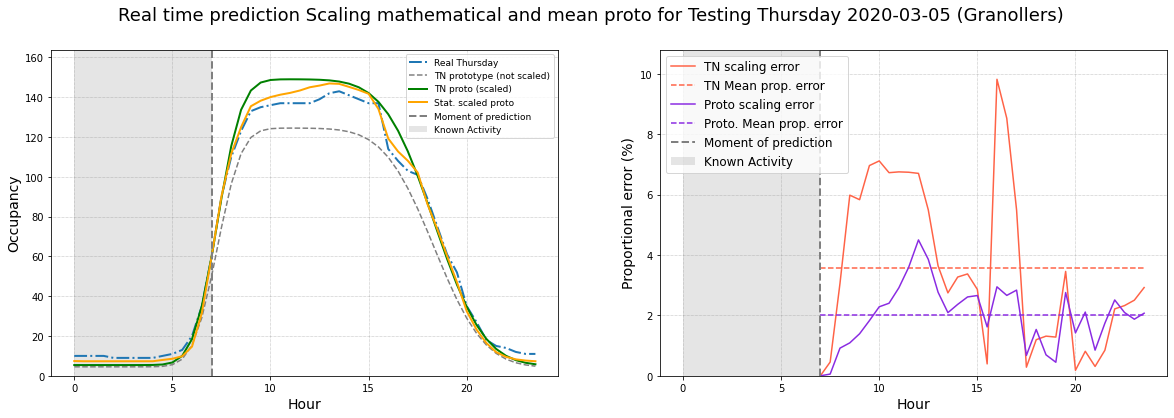

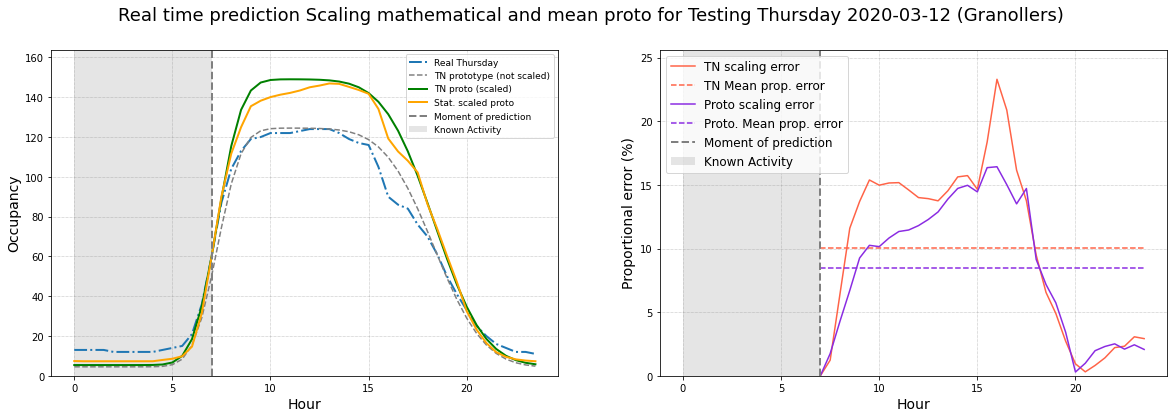

In [124]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

In [125]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday_nooff
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-21
Real Friday scaled prtotype error:  4.59 %
Real Friday scaled prtotype STDV:  1.1770863790454116
Real Friday scaled TN error:  3.29 %
Real Friday scaled TN STDV:  1.919363327090911
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  1.6 %
Real Friday scaled prtotype STDV:  0.983507250626317
Real Friday scaled TN error:  2.1 %
Real Friday scaled TN STDV:  1.3480857977756568
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  6.92 %
Real Friday scaled prtotype STDV:  1.85366171725591
Real Friday scaled TN error:  6.34 %
Real Friday scaled TN STDV:  1.0563648244369763
_____________________________________________________________


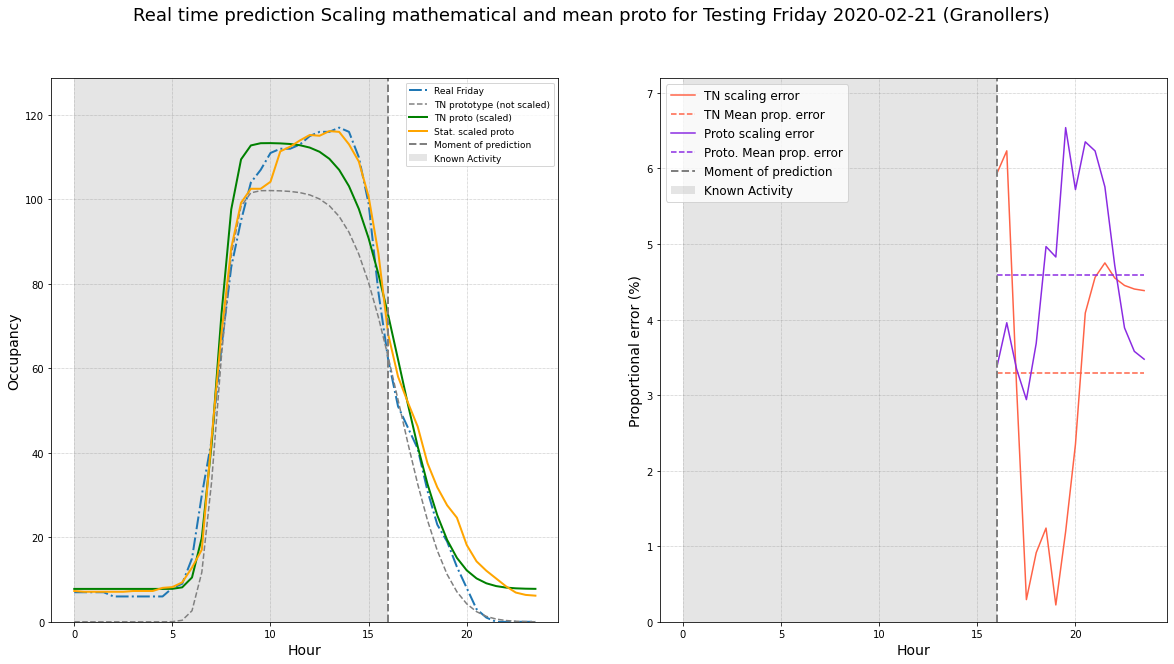

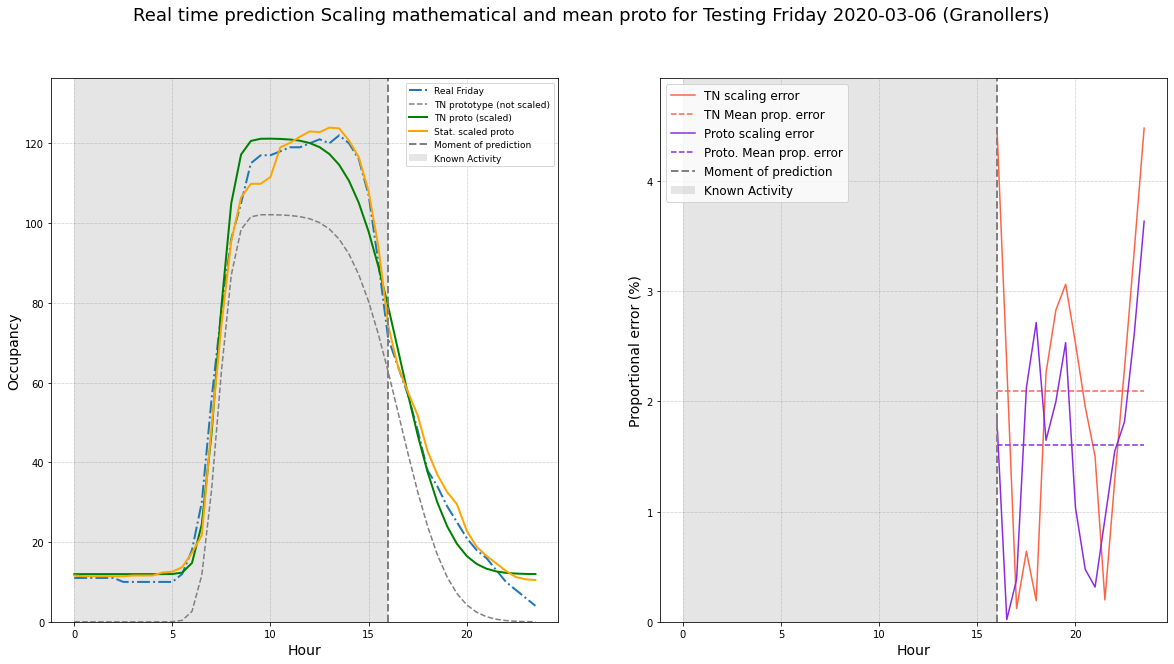

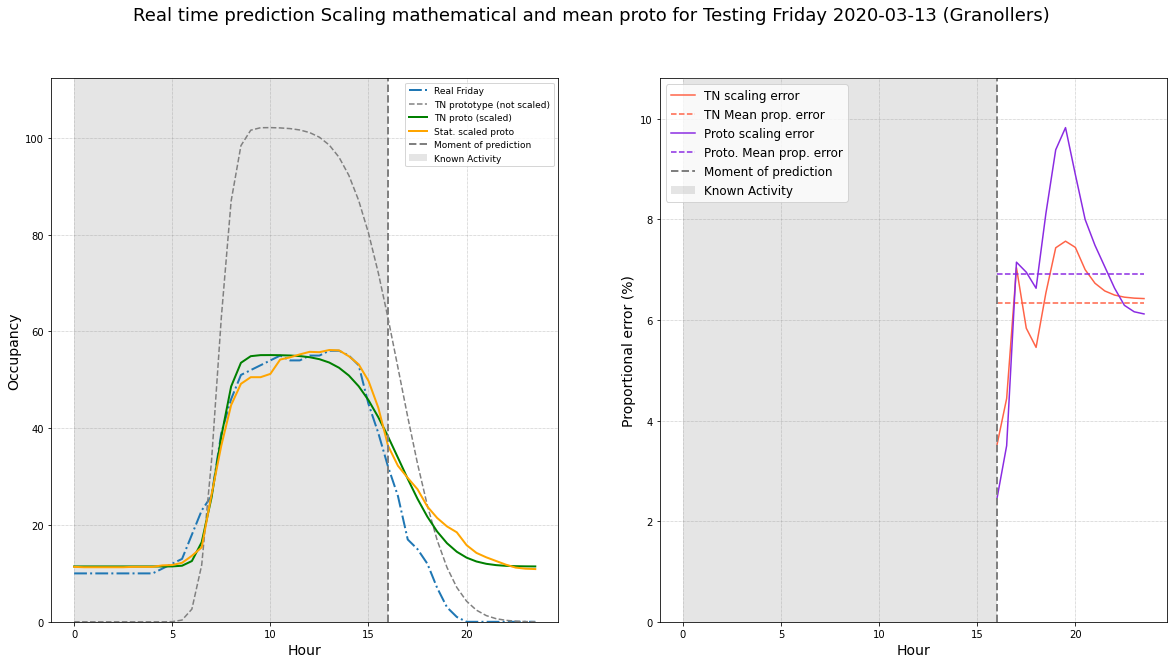

In [126]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

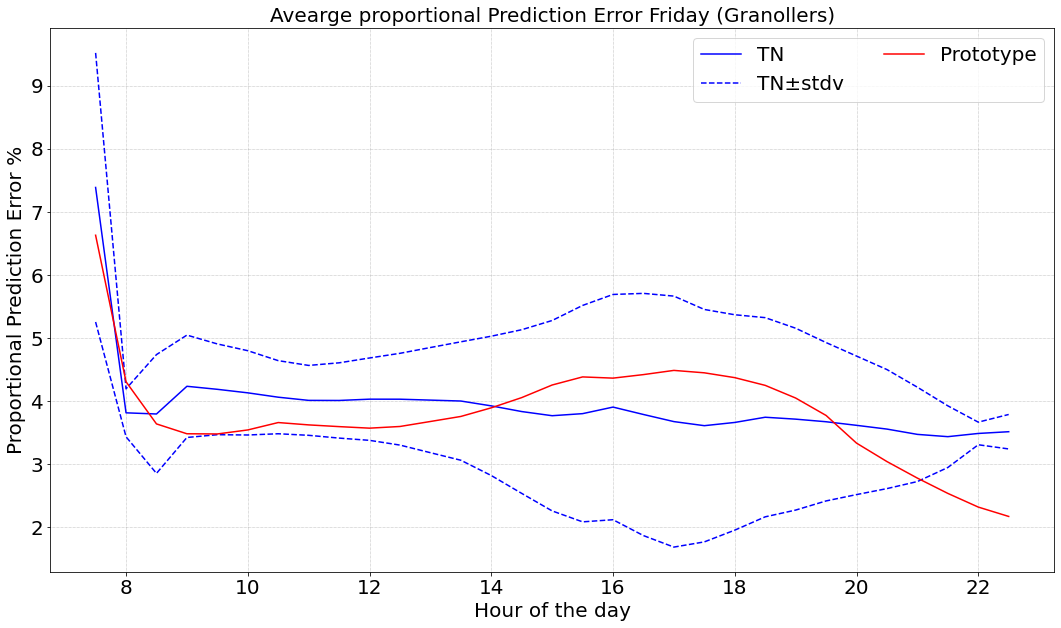

In [127]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
figH=plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [128]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

2020-02-21
Real Friday scaled prtotype error:  2.63 %
Real Friday scaled prtotype STDV:  1.5993076031691829
Real Friday scaled TN error:  1.81 %
Real Friday scaled TN STDV:  1.025229854817027
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  1.28 %
Real Friday scaled prtotype STDV:  0.9193335968131241
Real Friday scaled TN error:  4.73 %
Real Friday scaled TN STDV:  2.544307555424154
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  2.79 %
Real Friday scaled prtotype STDV:  1.6293720870530153
Real Friday scaled TN error:  1.21 %
Real Friday scaled TN STDV:  0.707213561765116
_____________________________________________________________


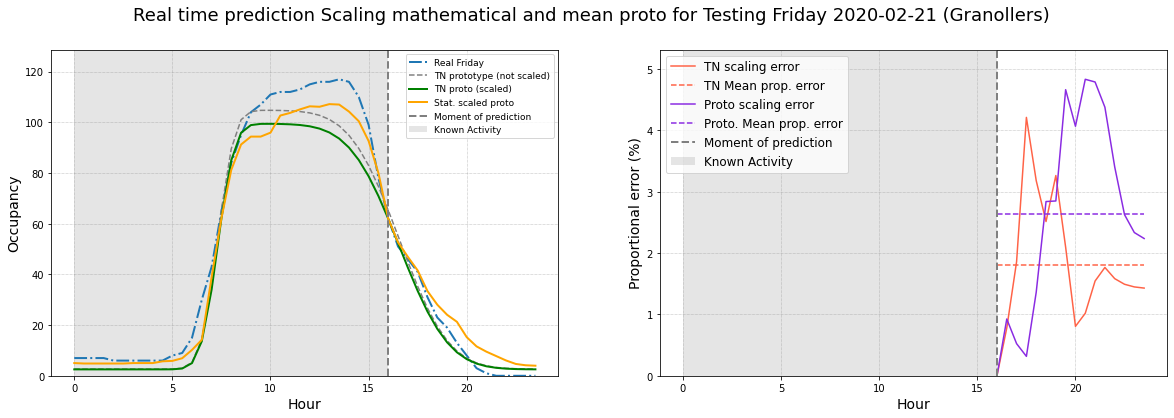

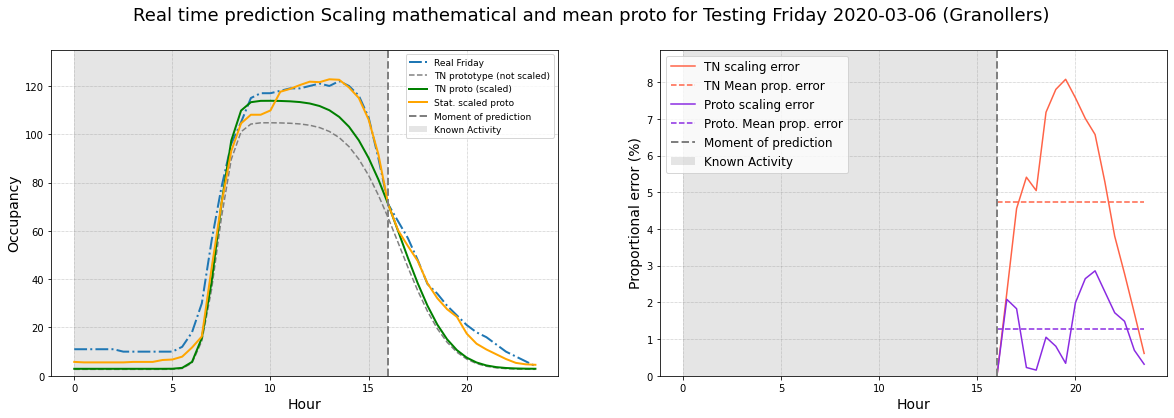

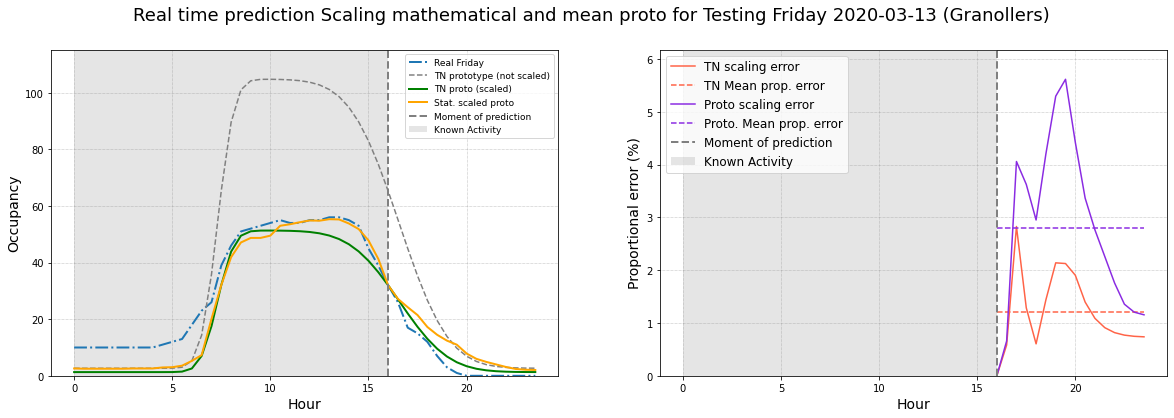

In [129]:
tn_proto = tn_friday 
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [130]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-03-07
Real Saturday scaled prtotype error:  2.62 %
Real Saturday scaled prtotype STDV:  1.2881075002951856
Real Saturday scaled TN error:  2.69 %
Real Saturday scaled TN STDV:  1.3578941200482963
_____________________________________________________________


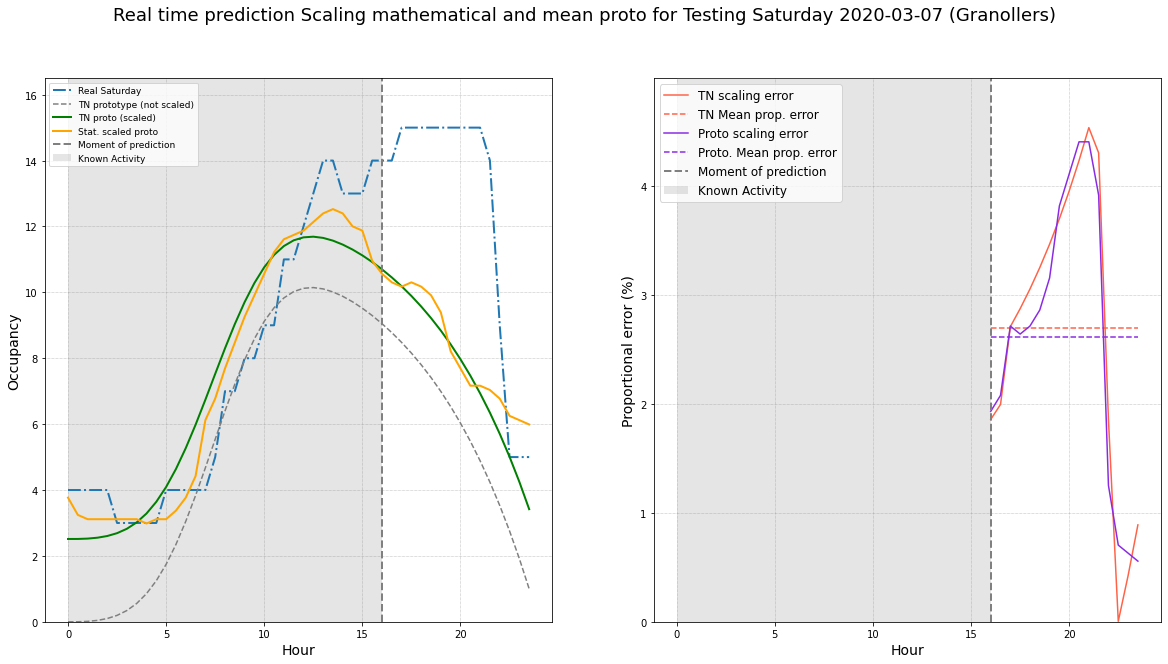

In [131]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

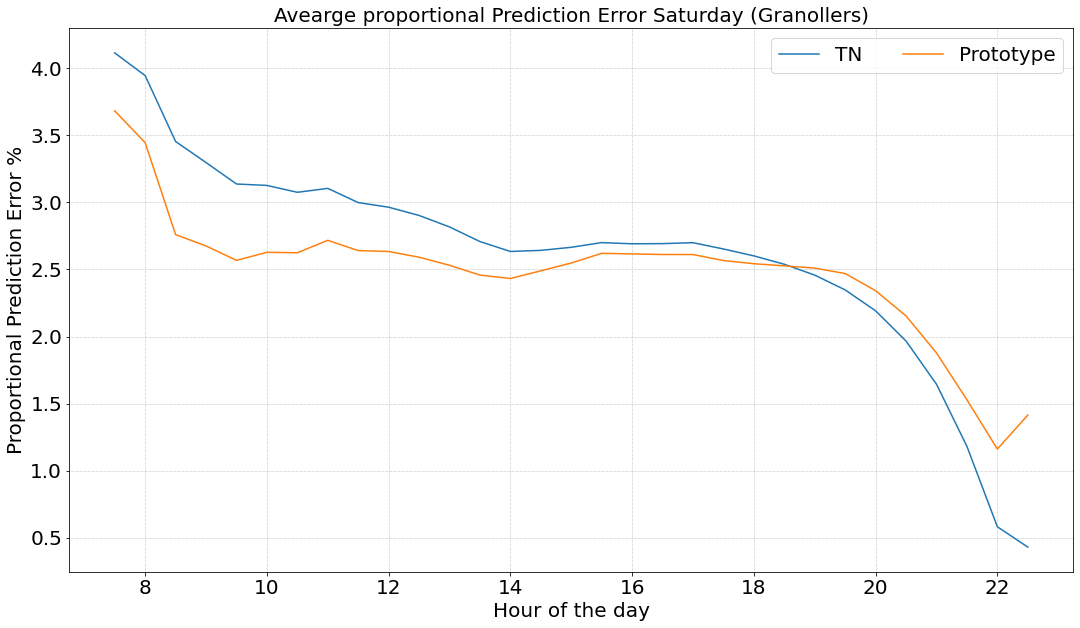

In [132]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [133]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-03-07
Real Saturday scaled prtotype error:  1.5 %
Real Saturday scaled prtotype STDV:  0.9043232548361761
Real Saturday scaled TN error:  1.4 %
Real Saturday scaled TN STDV:  0.8960886724224469
_____________________________________________________________


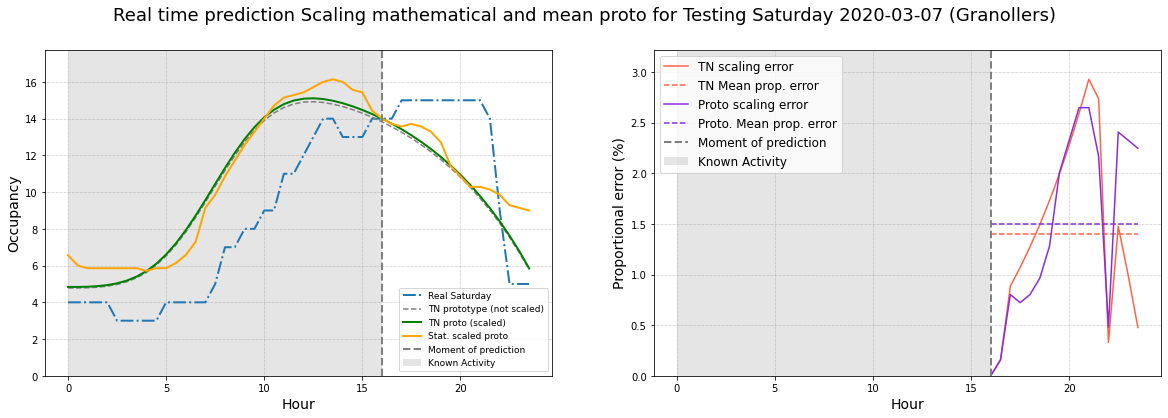

In [134]:
tn_proto = tn1_weekend        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [135]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    

2020-03-08
Real Sunday scaled prtotype error:  1.66 %
Real Sunday scaled prtotype STDV:  0.9348373136789003
Real Sunday scaled TN error:  1.75 %
Real Sunday scaled TN STDV:  0.9629458483777117
_____________________________________________________________


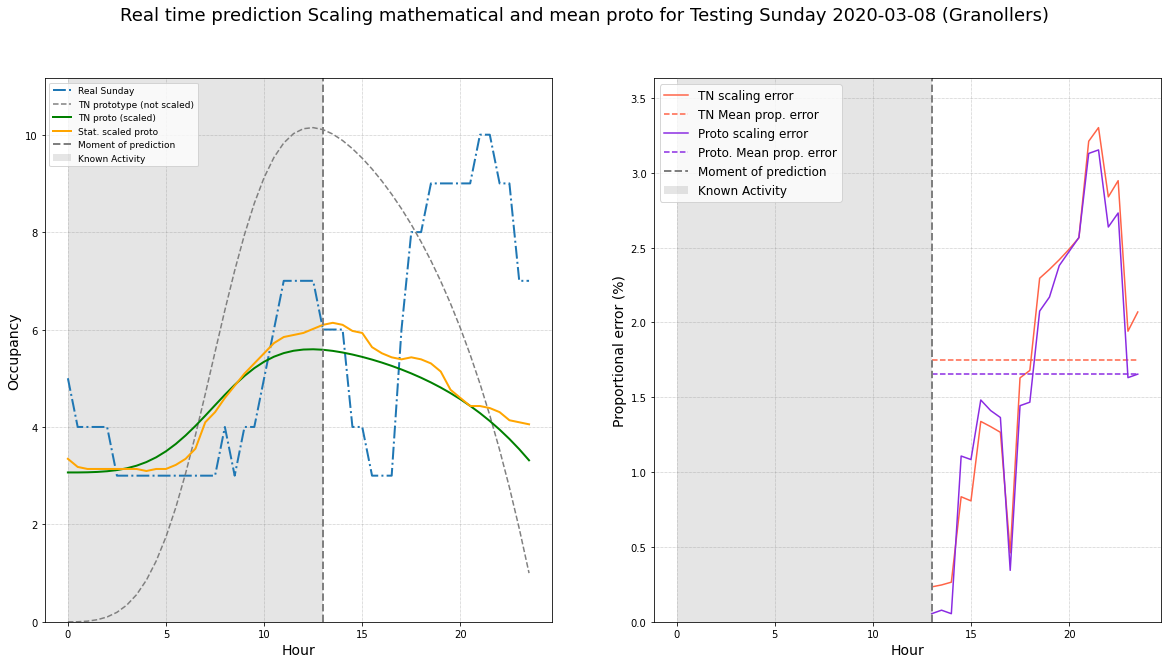

In [136]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

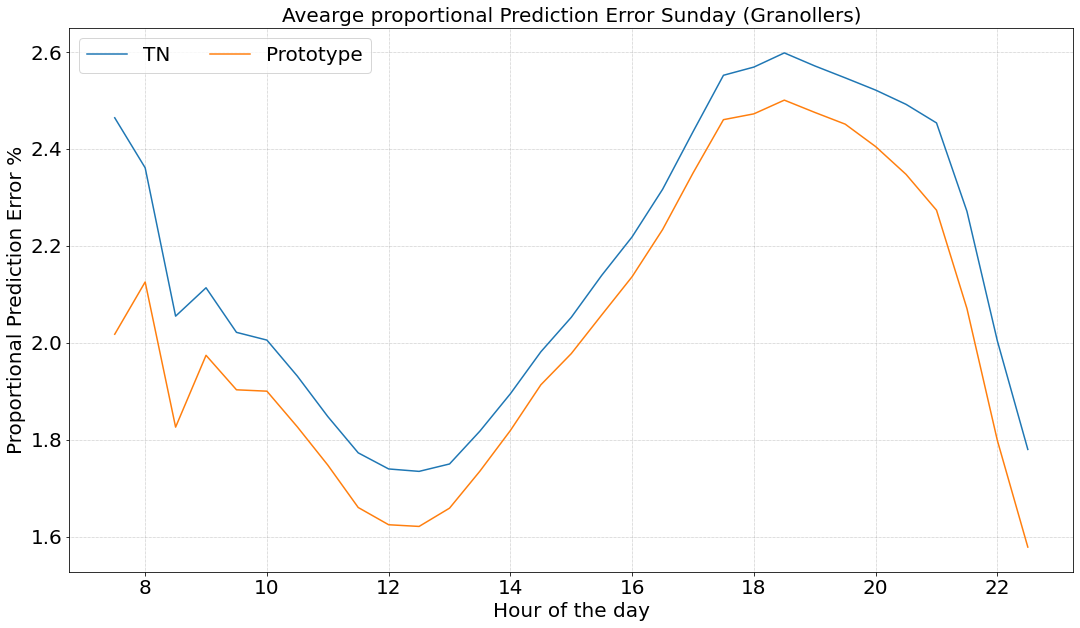

In [137]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [138]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

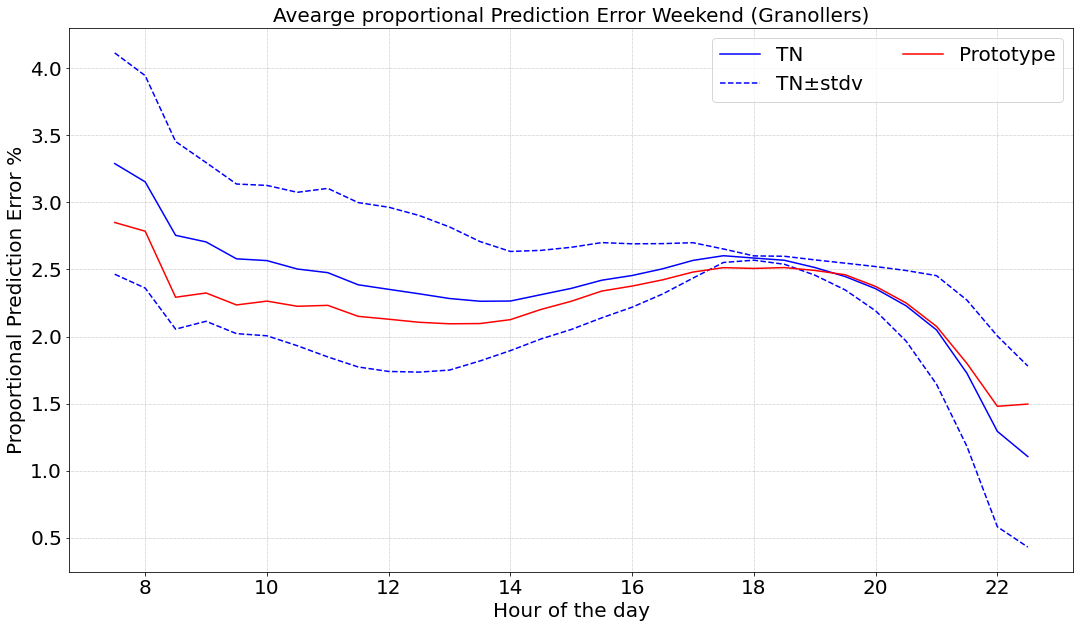

In [139]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

2020-03-08
Real Sunday scaled prtotype error:  1.8 %
Real Sunday scaled prtotype STDV:  1.0770541666665816
Real Sunday scaled TN error:  1.87 %
Real Sunday scaled TN STDV:  1.105182427934593
_____________________________________________________________


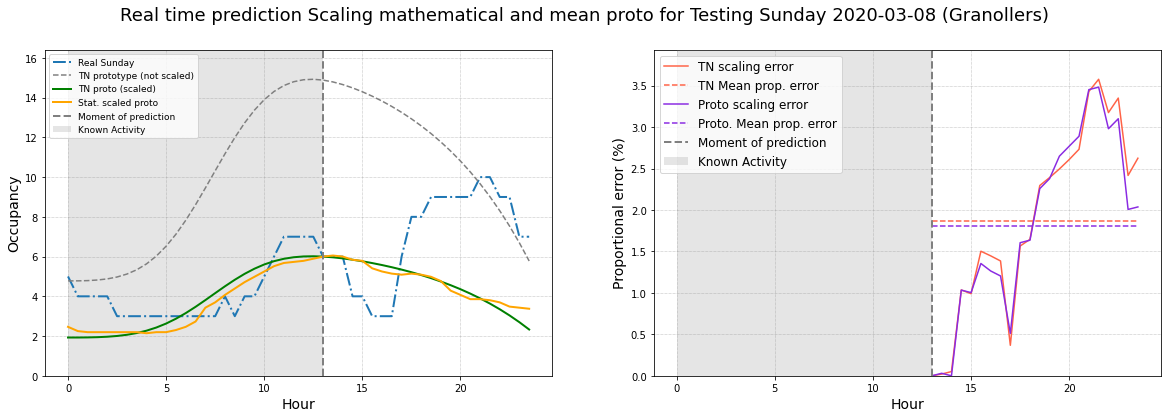

In [140]:
tn_proto = tn1_weekend
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [141]:
def plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,bol_plotstdv=False) :
    fsize=20
    #default colors:
    bd='#1f77b4'
    rd='#ff7f0e'
    gd='#2ca02c'
    limit_hour_vec = np.arange (starting_hour, 23, 0.5)
    fig=plt.figure(figsize=(18,10));
    plt.plot(limit_hour_vec,np.mean(tn_running_error_wd,axis=1),color=bd,label='Weekday: TN')
    plt.plot(limit_hour_vec,np.mean(proto_running_error_wd,axis=1),linestyle='dashdot',color=bd,
             label='Weekday: Prototype')
    #plt.plot(limit_hour_vec,np.mean(proto_running_error_wd,axis=1)+np.std(proto_running_error_wd,axis=1),
    #         linestyle='dashed',color='r',label='Prototype±stdv')
    #plt.plot(limit_hour_vec,np.mean(proto_running_error_wd,axis=1)-np.std(proto_running_error_wd,axis=1),
    #         linestyle='dashed',color='r')
    plt.plot(limit_hour_vec,np.mean(tn_running_error_fr,axis=1),color=rd,label='Friday: TN')

    plt.plot(limit_hour_vec,np.mean(proto_running_error_fr,axis=1),linestyle='dashdot',color=rd,
             label='Friday: Prototype')
             
    plt.plot(limit_hour_vec,np.mean(tn_running_error_we,axis=1),color=gd,label='Weekend: TN')
    
    if bol_plotstdv:
        plt.plot(limit_hour_vec,np.mean(tn_running_error_wd,axis=1)+np.std(tn_running_error_wd,axis=1),
             linestyle='dashed',color=bd,label='Weekday: TN±stdv')
        plt.plot(limit_hour_vec,np.mean(tn_running_error_wd,axis=1)-np.std(tn_running_error_wd,axis=1),
             linestyle='dashed',color=bd)
        plt.plot(limit_hour_vec,np.mean(tn_running_error_fr,axis=1)+np.std(tn_running_error_fr,axis=1),
             linestyle='dashed',color=rd,label='Friday: TN±stdv')
        plt.plot(limit_hour_vec,np.mean(tn_running_error_fr,axis=1)-np.std(tn_running_error_fr,axis=1),
             linestyle='dashed',color=rd)
        plt.plot(limit_hour_vec,np.mean(tn_running_error_we,axis=1)+np.std(tn_running_error_we,axis=1),
             linestyle='dashed',color=gd,label='Weekend: TN±stdv')
        plt.plot(limit_hour_vec,np.mean(tn_running_error_we,axis=1)-np.std(tn_running_error_we,axis=1),
             linestyle='dashed',color=gd)
    
    plt.plot(limit_hour_vec,np.mean(proto_running_error_we,axis=1),linestyle='dashdot',color=gd,
             label='Weekend: Prototype')
    plt.title("Avearge proportional Prediction Error ("+ current_parking+')', fontsize=fsize)
    plt.ylabel("Proportional Prediction Error %",fontsize=fsize);
    plt.xlabel("Hour of the day",fontsize=fsize);
    plt.yticks(fontsize=fsize)
    plt.xticks(fontsize=fsize);
    plt.xlim([starting_hour,22.5])
    plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
    plt.legend(fontsize=fsize, loc="best",ncol=3);
    return fig

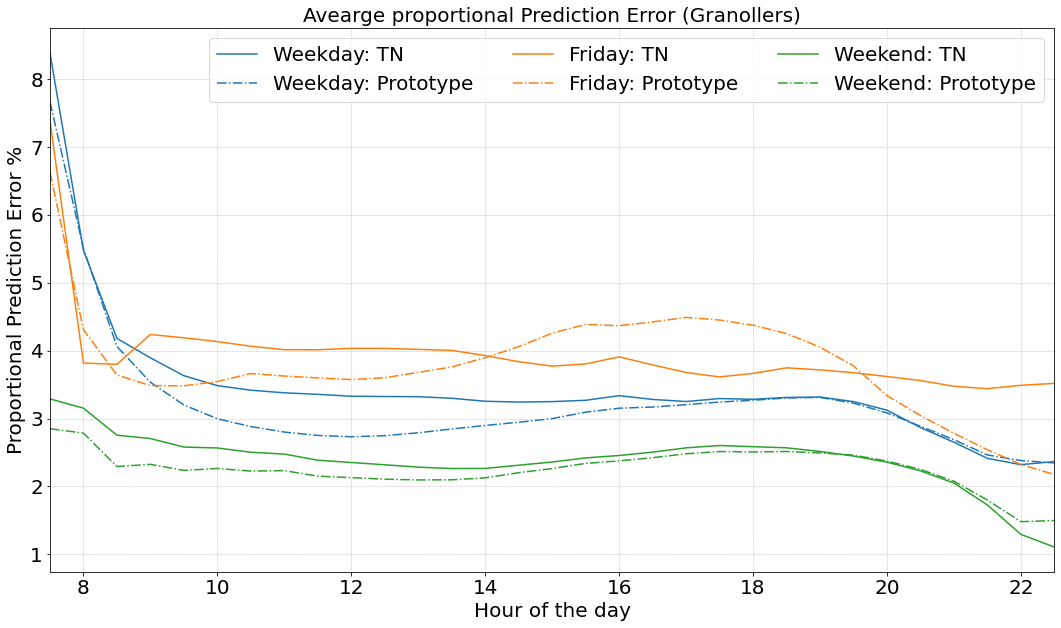

In [142]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'.pdf',bbox_inches='tight');